# Task for Cuetessa, Inc. – Predicting Valence of Pop Songs


## Overview
The aim of this task is to develop a Python-based module to predict the valence of newly released pop songs.  Two approaches are to use as input 
1. the audio data (e.g., .wav files) of songs  
2. the lyrics of songs.  Publicly available datasets can be used for training and testing. 

Valence is the musical positiveness conveyed by a song, ranging from sad/depressed to happy/cheerful.

This project aims to apply Bidirectional Encoder Representations from Transformers (BERT) model to predict and classify the genres and emotions based on the
Song Lyrics. We hope those predictions can facilitate the automation of the music
industry.


### Data Description 

[Lyrics dataset](https://www.kaggle.com/datasets/edenbd/150k-lyrics-labeled-with-spotify-valence?resource=download) on Kaggle that contains:
- full lyrics and labels of more than 150,000 songs 
- The label is the Spotify valence attribute, ranging from 0 to 1. 
    - It describes the musical positiveness conveyed by a track. 
    - Tracks with high valence sound more positive (happy, cheerful), while tracks with low valence sound more negative (sad, depressed).
    
### Feature Extraction
In this version of the project, the approach of the following research paper will be implemented: [Measuring national mood with music](https://link.springer.com/article/10.3758/s13428-021-01747-7). These features are:
- [x] Spectral Centroid;
- [x] Spectral Rolloff;
- [x] Spectral Contrast — ~~7 bands~~ *(kept the default 6 bands instead)*;
- [x] Mel-Frequency Cepstrum Coefficients (MFCC) — 24 coefficients;
- [x] Zero Crossing Rate;
- [x] Chroma Energy Normalized Statistics (CENS) — 12 chroma;
- [x] Beat Per Minute (BPM);
- [x] Root Mean Square (RMS);

## Initialization 


In [1]:
# Initialization 

import pandas as pd
import numpy as np
import requests 

# statistical visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig
import seaborn as sns

# import librosa for audio feature extraction
import librosa as librosa
import librosa.display as ld
import IPython.display as ipd

# import Snowball Stemmer for genre categorization
from nltk.stem import SnowballStemmer
import os
import re
from tqdm import tqdm

# import module for splitting and cross-validation using gridsearch
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler

# import machine learning module from the sklearn library
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from imblearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm
from time import time
from datetime import date

# spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials


import torch
import transformers

# import warnings
import warnings
warnings.filterwarnings("ignore")




In [3]:
# Set up some parameters for building plots
#plt.style.use("seaborn-v0_8")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("cubehelix")

plt.rcParams["figure.figsize"] = (9, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline

## Data Preprocessing

In [3]:
# Load dataset and rename columns for a clearer understanding
df = pd.read_csv('/Users/gguillau/Desktop/Practicum/Cuetessa Project/labeled_lyrics_cleaned.csv')
df.rename(columns= {'label': 'valence', 'seq':'lyrics'}, inplace=True)

In [4]:
# Visualize dataset with new column names
display(df)

Unnamed: 0        artist  \
0                0  Elijah Blake   
1                1  Elijah Blake   
2                2  Elijah Blake   
3                3  Elijah Blake   
4                4  Elijah Blake   
...            ...           ...   
158348      158348    Adam Green   
158349      158349    Adam Green   
158350      158350    Adam Green   
158351      158351    Adam Green   
158352      158352    Adam Green   

                                                   lyrics                song  \
0       No, no\r\nI ain't ever trapped out the bando\r...            Everyday   
1       The drinks go down and smoke goes up, I feel m...    Live Till We Die   
2       She don't live on planet Earth no more\r\nShe ...       The Otherside   
3       Trippin' off that Grigio, mobbin', lights low\...               Pinot   
4       I see a midnight panther, so gallant and so br...  Shadows & Diamonds   
...                                                   ...                 ...   
158348  And we live on borrowed time,\r\nBut this head...     Friends of Mine   
158349  Frozin in time forever\r\nCarrying that torch ...      Frozen in Time   
158350  Hard to be a girl. \r\nSo nice to be a boy. \r...   Hard to Be a Girl   
158351  I want to chose to die,\r\nAnd be buried with ...         I Wanna Die   
158352  Musical ladders\r\nLeaning on mountains\r\nBat...     Musical Ladders   

        valence  
0         0.626  
1         0.630  
2         0.240  
3         0.536  
4         0.371  
...         ...  
158348    0.737  
158349    0.482  
158350    0.733  
158351    0.361  
158352    0.263  

[158353 rows x 5 columns]

In [2]:
# function to determine if columns in file have null values
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
# function to display general information about the dataset
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe)
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 4))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")

In [6]:
# study the general information about the internet dataset 

get_info(df)

----------------------------------------------------------------------------------------------------
Head:



Unnamed: 0        artist  \
0           0  Elijah Blake   
1           1  Elijah Blake   
2           2  Elijah Blake   
3           3  Elijah Blake   
4           4  Elijah Blake   

                                              lyrics                song  \
0  No, no\r\nI ain't ever trapped out the bando\r...            Everyday   
1  The drinks go down and smoke goes up, I feel m...    Live Till We Die   
2  She don't live on planet Earth no more\r\nShe ...       The Otherside   
3  Trippin' off that Grigio, mobbin', lights low\...               Pinot   
4  I see a midnight panther, so gallant and so br...  Shadows & Diamonds   

   valence  
0    0.626  
1    0.630  
2    0.240  
3    0.536  
4    0.371

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158353 entries, 0 to 158352
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  158353 non-null  int64  
 1   artist      158353 non-null  object 
 2   lyrics      158353 non-null  object 
 3   song        158353 non-null  object 
 4   valence     158353 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.0+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



Unnamed: 0        valence
count  158353.000000  158353.000000
mean    79176.000000       0.491052
std     45712.717926       0.249619
min         0.000000       0.000000
25%     39588.000000       0.286000
50%     79176.000000       0.483000
75%    118764.000000       0.691000
max    158352.000000       0.998000

----------------------------------------------------------------------------------------------------


<bound method NDFrame.describe of         Unnamed: 0        artist  \
0                0  Elijah Blake   
1                1  Elijah Blake   
2                2  Elijah Blake   
3                3  Elijah Blake   
4                4  Elijah Blake   
...            ...           ...   
158348      158348    Adam Green   
158349      158349    Adam Green   
158350      158350    Adam Green   
158351      158351    Adam Green   
158352      158352    Adam Green   

                                                   lyrics                song  \
0       No, no\r\nI ain't ever trapped out the bando\r...            Everyday   
1       The drinks go down and smoke goes up, I feel m...    Live Till We Die   
2       She don't live on planet Earth no more\r\nShe ...       The Otherside   
3       Trippin' off that Grigio, mobbin', lights low\...               Pinot   
4       I see a midnight panther, so gallant and so br...  Shadows & Diamonds   
...                                            


Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(158353, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [7]:
# Clean lyrics column
df['lyrics'] =  [re.sub(r"\n", " ", string) for string in df['lyrics']]
df['lyrics'] =  [re.sub(r"\r", " ", string) for string in df['lyrics']]

In [8]:
# Visualize cleaned lyrics column
df['lyrics'].head(20)

0     No, no  I ain't ever trapped out the bando  Bu...
1     The drinks go down and smoke goes up, I feel m...
2     She don't live on planet Earth no more  She fo...
3     Trippin' off that Grigio, mobbin', lights low ...
4     I see a midnight panther, so gallant and so br...
5     I just want to ready your mind  'Cause I'll st...
6     To believe  Or not to believe  That is the que...
7     Dieses ist lange her.  Da ich deine schmalen H...
8     A child is born  Out of the womb of a mother  ...
9     Out of the darkness you came   You looked so t...
10    Each night I lie in my bed   And I think about...
11    Nebel zieh'n gespentisch vor   Der Sucher setz...
12    I'm a lonely stranger   In this world of pain ...
13    Schwere Tranen   Vergebens geweint   Rinnen wi...
14    Come calm my anger  Our love is like a perfect...
15    I was walking through the night Suddenly I rem...
16    Why can't I hear you breath Why can't I hold y...
17    Your cold cold heart has drowned my life i

In [9]:
# Drop redundant column
df.drop('Unnamed: 0', axis=1, inplace=True)

### Spotify API Data Extraction

In [10]:
# Spotify API
cid = "851724c9cd454f1ca279898a01ba1edd"
secret = "d551a33f3fac45089576fb9e0f6b9e06"

In [11]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)


In [12]:
# Take a random sample from original dataset
data = df.sample(frac=0.0032, random_state=12345)
data.reset_index(inplace=True)

# drop index column
data.drop('index',axis=1,inplace=True)
data


artist                                             lyrics  \
0     Letters to Cleo  The saddest sound I've ever heard; the saddest...   
1      Gregory Isaacs  I thought it would be better  Now I'm a brande...   
2               HONNE  Ten out of ten  You killed it once again  'Cau...   
3        Richard Marx  We're all victims of the system  Still we love...   
4    Billy Currington  Hey, girl, what's your name, girl I've been lo...   
..                ...                                                ...   
502           Cibelle  Sitting, staring At my cigarette ash Hmm...  W...   
503        The Police  If blood will flow when flesh and steel are on...   
504       Jethro Tull  In the dark of the city backwoods  Something s...   
505     Lynn Anderson  [Honey, I know I've said it too many times bef...   
506   John Mellencamp  Everybody's talking 'bout the seventh son In t...   

                     song  valence  
0                  Wasted    0.465  
1             Hot Stepper    0.934  
2                   Woman    0.246  
3    Hands in Your Pocket    0.789  
4                Hey Girl    0.652  
..                    ...      ...  
502               Waiting    0.511  
503               Fragile    0.212  
504  Jump Start [Live][*]    0.276  
505       Honey Come Back    0.486  
506       Seventh Son [*]    0.807  

[507 rows x 4 columns]

In [13]:
# Round down to 39500 rows
data = data.loc[:499]
len(data)

500

In [14]:
# Get artist names
artists = data.artist.unique()
num_artists = len(artists)
num_artists_found = 0
artists
artists = artists.tolist()
artists


['Letters to Cleo',
 'Gregory Isaacs',
 'HONNE',
 'Richard Marx',
 'Billy Currington',
 'Merl Saunders',
 'Jimmy Rushing',
 'Ghostface Killah',
 'Ellie Goulding',
 'Frank Sinatra',
 'Alice Peacock',
 'Dungeon Family',
 'The Bosshoss',
 'Gene Clark',
 'Steps',
 'Prong',
 'Tish Hinojosa',
 'Scarface',
 'Human Nature',
 'Darden Smith',
 'Elton John',
 'Porcupine Tree',
 'John Waite',
 'Mindy Smith',
 'Hot Chocolate',
 'Evolution',
 'Glenn Miller',
 'Sugar Ray',
 'Merle Haggard',
 'Vaughn Monroe',
 'The Gaslight Anthem',
 'Patti Austin',
 'Justin Bieber',
 'Big Daddy Kane',
 'Averi',
 'Ultravox',
 'New Order',
 'Mark Marino',
 'Bobby Bare',
 'They Might Be Giants',
 'The Statler Brothers',
 'Tony Bennett',
 'Coolio',
 'Phillips, Craig & Dean',
 'The Escape Club',
 'Anvil',
 'Sarah Vaughan',
 'Theresa Ronning',
 'Najwa',
 'Sheek Louch',
 'Soraya ',
 'Roger Whittaker',
 'Brantley Gilbert',
 'Neil Diamond',
 'Rod Stewart',
 'Volbeat',
 'The Pogues',
 'George Strait',
 'Marsha Ambrosius',
 'So

In [15]:
# Get artist_URI
artist_URI = []
for i in tqdm(range(num_artists)):
    artist_name = data.loc[i, "artist"]
    try:
        artists = sp.search(q="artist:" + artist_name, type="artist", limit=1)
        artist_URI = artists["artists"]["items"][0]["uri"]
        data.loc[i, "artist_uri"] = artist_URI
        num_artists_found += 1
    except:
        data.loc[i, "artist_uri"] = None

print(f"Artists found: {num_artists_found}")

df1 = data.dropna().reset_index(drop=True)
df1.head()


100%|█████████████████████████████████████████| 435/435 [00:39<00:00, 11.00it/s]


Artists found: 435


artist                                             lyrics  \
0   Letters to Cleo  The saddest sound I've ever heard; the saddest...   
1    Gregory Isaacs  I thought it would be better  Now I'm a brande...   
2             HONNE  Ten out of ten  You killed it once again  'Cau...   
3      Richard Marx  We're all victims of the system  Still we love...   
4  Billy Currington  Hey, girl, what's your name, girl I've been lo...   

                   song  valence                             artist_uri  
0                Wasted    0.465  spotify:artist:7E41j1yL9ZeTWfqe9bUGgw  
1           Hot Stepper    0.934  spotify:artist:6QHu71f8LLeT8n0GzfbYFc  
2                 Woman    0.246  spotify:artist:0Vw76uk7P8yVtTClWyOhac  
3  Hands in Your Pocket    0.789  spotify:artist:0grdhNhiRLFBaFVyybqsj6  
4              Hey Girl    0.652  spotify:artist:1By9QBFnjZAoI83BZppHlt

A URI (Uniform Resource Indicator) is a link that you can find in the Share menu of any track, album, or Artist Profile on Spotify.

In [16]:
# Get song URI
song_URI = []
num_songs = df1.song.nunique()
num_songs
num_songs_found = 0



In [17]:
# Get URI for each artist from the list

for i in tqdm(range(num_songs)):
    artist_URI = data.loc[i, "artist_uri"]

    artist_name = df1.loc[i, "artist"]
    song_name = df1.loc[i, "song"]
    try:
        songs = sp.search(q="artist:" + artist_name + " track:" + song_name, type="track", limit=1)
        song_URI = songs["tracks"]["items"][0]['uri']
        preview_url = songs["tracks"]["items"][0]['preview_url']
        song_id = songs["tracks"]["items"][0]['id']
        df1.loc[i, "song_id"] = song_id
        df1.loc[i, "song_URI"] = song_URI
        df1.loc[i,"preview_url"] = preview_url
        df1.loc[i, "genre"] = sp.artist(artist_URI)["genres"][0]

        num_songs_found += 1
    except:
        pass

df1.head()

100%|█████████████████████████████████████████| 432/432 [01:40<00:00,  4.28it/s]


artist                                             lyrics  \
0   Letters to Cleo  The saddest sound I've ever heard; the saddest...   
1    Gregory Isaacs  I thought it would be better  Now I'm a brande...   
2             HONNE  Ten out of ten  You killed it once again  'Cau...   
3      Richard Marx  We're all victims of the system  Still we love...   
4  Billy Currington  Hey, girl, what's your name, girl I've been lo...   

                   song  valence                             artist_uri  \
0                Wasted    0.465  spotify:artist:7E41j1yL9ZeTWfqe9bUGgw   
1           Hot Stepper    0.934  spotify:artist:6QHu71f8LLeT8n0GzfbYFc   
2                 Woman    0.246  spotify:artist:0Vw76uk7P8yVtTClWyOhac   
3  Hands in Your Pocket    0.789  spotify:artist:0grdhNhiRLFBaFVyybqsj6   
4              Hey Girl    0.652  spotify:artist:1By9QBFnjZAoI83BZppHlt   

                  song_id                              song_URI  \
0  1hUkQE51UrZfq7XxqFDkv9  spotify:track:1hUkQE51UrZfq7XxqFDkv9   
1  5S0lcuJlVSUrhC3AuuZNwY  spotify:track:5S0lcuJlVSUrhC3AuuZNwY   
2  6YpSiNQN8pVzJMOX2fXGHm  spotify:track:6YpSiNQN8pVzJMOX2fXGHm   
3  2uTpWrFRBfeXHq7DtrSzFq  spotify:track:2uTpWrFRBfeXHq7DtrSzFq   
4  4CcrLWFQY4dRGMbUR59cSp  spotify:track:4CcrLWFQY4dRGMbUR59cSp   

                                         preview_url                 genre  
0  https://p.scdn.co/mp3-preview/a21a04f0773faf75...       alternative pop  
1  https://p.scdn.co/mp3-preview/3b5534d30d9d4973...                   dub  
2  https://p.scdn.co/mp3-preview/b956fbd942363aea...                   pop  
3  https://p.scdn.co/mp3-preview/299f662664d0aae0...            album rock  
4  https://p.scdn.co/mp3-preview/413f5a35ec3269d9...  contemporary country

In [18]:
df1.isna().sum()

artist          0
lyrics          0
song            0
valence         0
artist_uri      0
song_id        13
song_URI       13
preview_url    13
genre          48
dtype: int64

In [19]:
df1.dropna(inplace=True)
df1.isna().sum()
#df1.info()

artist         0
lyrics         0
song           0
valence        0
artist_uri     0
song_id        0
song_URI       0
preview_url    0
genre          0
dtype: int64

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 0 to 431
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   artist       387 non-null    object 
 1   lyrics       387 non-null    object 
 2   song         387 non-null    object 
 3   valence      387 non-null    float64
 4   artist_uri   387 non-null    object 
 5   song_id      387 non-null    object 
 6   song_URI     387 non-null    object 
 7   preview_url  387 non-null    object 
 8   genre        387 non-null    object 
dtypes: float64(1), object(8)
memory usage: 30.2+ KB


In [21]:
# Extract other music attributes using spotify API
music_attributes = ["tempo", "energy", "danceability", "loudness"]

for i in tqdm(range(df1.shape[0])):
    try:
        song_uri = df1.loc[i, "song_URI"]

        audio_features = sp.audio_features(song_uri)[0]
    except:
        pass
    for attribute in music_attributes:
        try:
            df1.loc[i, attribute] = audio_features[attribute]

        except:
            df1.loc[i, attribute] = None

df1.info()

100%|█████████████████████████████████████████| 387/387 [00:41<00:00,  9.22it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 378
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist        387 non-null    object 
 1   lyrics        387 non-null    object 
 2   song          387 non-null    object 
 3   valence       387 non-null    float64
 4   artist_uri    387 non-null    object 
 5   song_id       387 non-null    object 
 6   song_URI      387 non-null    object 
 7   preview_url   387 non-null    object 
 8   genre         387 non-null    object 
 9   tempo         387 non-null    float64
 10  energy        387 non-null    float64
 11  danceability  387 non-null    float64
 12  loudness      387 non-null    float64
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


In [22]:
df1.dropna(inplace=True)
df1.isna().sum()

artist          0
lyrics          0
song            0
valence         0
artist_uri      0
song_id         0
song_URI        0
preview_url     0
genre           0
tempo           0
energy          0
danceability    0
loudness        0
dtype: int64

In [23]:
df1.reset_index(inplace=True)

In [24]:
# Download audio files
for i in tqdm(range(df1.shape[0])):

    url = df1.loc[i, "preview_url"]
    song_id = df1.loc[i, "song_id"]
    file_path = f"/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/{song_id}.mp3"

    try:
        r = requests.get(url, timeout=5)
        with open(file_path, "wb") as f:
            f.write(r.content)
        df1.loc[i, "file_name"] = f"{song_id}.mp3"
        df1.loc[i, "file_path"] = file_path
    except:
        pass

100%|█████████████████████████████████████████| 350/350 [01:01<00:00,  5.70it/s]


In [25]:
# see how many tracks are duplicates

print(df1.duplicated(subset=["song", "song_id",'file_path']).sum())

# drop duplicated tracks from the dataframe
#df1.drop_duplicates(subset=["song", "song_id",'file_path'], inplace=True)


0


In [26]:
df1

index                 artist  \
0        0        Letters to Cleo   
1        1         Gregory Isaacs   
2        2                  HONNE   
3        3           Richard Marx   
4        4       Billy Currington   
..     ...                    ...   
345    382         Rachel Stevens   
346    383               Megadeth   
347    384           The Supremes   
348    385  Ramblin' Jack Elliott   
349    386        Ella Fitzgerald   

                                                lyrics  \
0    The saddest sound I've ever heard; the saddest...   
1    I thought it would be better  Now I'm a brande...   
2    Ten out of ten  You killed it once again  'Cau...   
3    We're all victims of the system  Still we love...   
4    Hey, girl, what's your name, girl I've been lo...   
..                                                 ...   
345  Yeah    You got the time, I got the money  We'...   
346  I barely get to the graveyard shift on time  A...   
347  For your lovin', oh, oh, yeah  Oh, oh, yeah, w...   
348  It was early springtime that the strike was on...   
349  We're going through the impatient years  The y...   

                        song  valence                             artist_uri  \
0                     Wasted    0.465  spotify:artist:7E41j1yL9ZeTWfqe9bUGgw   
1                Hot Stepper    0.934  spotify:artist:6QHu71f8LLeT8n0GzfbYFc   
2                      Woman    0.246  spotify:artist:0Vw76uk7P8yVtTClWyOhac   
3       Hands in Your Pocket    0.789  spotify:artist:0grdhNhiRLFBaFVyybqsj6   
4                   Hey Girl    0.652  spotify:artist:1By9QBFnjZAoI83BZppHlt   
..                       ...      ...                                    ...   
345          I Got the Money    0.848  spotify:artist:7LP4hiTAVkw3Rtc1hqtLi4   
346   The Right to Go Insane    0.538  spotify:artist:1Yox196W7bzVNZI7RBaPnf   
347  It's Time to Break Down    0.942  spotify:artist:57bUPid8xztkieZfS7OlEV   
348          Ludlow Massacre    0.498  spotify:artist:6iuM8yp1x2N0l6SONhyq4b   
349      The Impatient Years    0.223  spotify:artist:5V0MlUE1Bft0mbLlND7FJz   

                    song_id                              song_URI  \
0    1hUkQE51UrZfq7XxqFDkv9  spotify:track:1hUkQE51UrZfq7XxqFDkv9   
1    5S0lcuJlVSUrhC3AuuZNwY  spotify:track:5S0lcuJlVSUrhC3AuuZNwY   
2    6YpSiNQN8pVzJMOX2fXGHm  spotify:track:6YpSiNQN8pVzJMOX2fXGHm   
3    2uTpWrFRBfeXHq7DtrSzFq  spotify:track:2uTpWrFRBfeXHq7DtrSzFq   
4    4CcrLWFQY4dRGMbUR59cSp  spotify:track:4CcrLWFQY4dRGMbUR59cSp   
..                      ...                                   ...   
345  5Vira9mKFgZReabMPhNNhF  spotify:track:5Vira9mKFgZReabMPhNNhF   
346  5bILDCXPGi8U8rgfS75gbo  spotify:track:5bILDCXPGi8U8rgfS75gbo   
347  6YQ1iVb2mGvkL5VOB8rwJx  spotify:track:6YQ1iVb2mGvkL5VOB8rwJx   
348  54fqkcCzOzYfvXd80mMkce  spotify:track:54fqkcCzOzYfvXd80mMkce   
349  1jtoAyt8pHl8HLWqr5SDVZ  spotify:track:1jtoAyt8pHl8HLWqr5SDVZ   

                                           preview_url                  genre  \
0    https://p.scdn.co/mp3-preview/a21a04f0773faf75...        alternative pop   
1    https://p.scdn.co/mp3-preview/3b5534d30d9d4973...                    dub   
2    https://p.scdn.co/mp3-preview/b956fbd942363aea...                    pop   
3    https://p.scdn.co/mp3-preview/299f662664d0aae0...             album rock   
4    https://p.scdn.co/mp3-preview/413f5a35ec3269d9...   contemporary country   
..                                                 ...                    ...   
345  https://p.scdn.co/mp3-preview/6585f854dbab1637...        bubblegum dance   
346  https://p.scdn.co/mp3-preview/df81f796d28d9f57...      alternative metal   
347  https://p.scdn.co/mp3-preview/0744f32eb7bfc4d7...        adult standards   
348  https://p.scdn.co/mp3-preview/f24027d53bd65043...  american folk revival   
349  https://p.scdn.co/mp3-preview/b78b6884c715cf5c...        adult standards   

       tempo  energy  danceability  loudness                   file_name  \
0    173.239   0.852    

In [27]:
df1.to_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/data/songs_data.csv", index=False)

In [28]:
#df1 = pd.readcsv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/data/songs_data.csv")

In [28]:
df1

index                 artist  \
0        0        Letters to Cleo   
1        1         Gregory Isaacs   
2        2                  HONNE   
3        3           Richard Marx   
4        4       Billy Currington   
..     ...                    ...   
345    382         Rachel Stevens   
346    383               Megadeth   
347    384           The Supremes   
348    385  Ramblin' Jack Elliott   
349    386        Ella Fitzgerald   

                                                lyrics  \
0    The saddest sound I've ever heard; the saddest...   
1    I thought it would be better  Now I'm a brande...   
2    Ten out of ten  You killed it once again  'Cau...   
3    We're all victims of the system  Still we love...   
4    Hey, girl, what's your name, girl I've been lo...   
..                                                 ...   
345  Yeah    You got the time, I got the money  We'...   
346  I barely get to the graveyard shift on time  A...   
347  For your lovin', oh, oh, yeah  Oh, oh, yeah, w...   
348  It was early springtime that the strike was on...   
349  We're going through the impatient years  The y...   

                        song  valence                             artist_uri  \
0                     Wasted    0.465  spotify:artist:7E41j1yL9ZeTWfqe9bUGgw   
1                Hot Stepper    0.934  spotify:artist:6QHu71f8LLeT8n0GzfbYFc   
2                      Woman    0.246  spotify:artist:0Vw76uk7P8yVtTClWyOhac   
3       Hands in Your Pocket    0.789  spotify:artist:0grdhNhiRLFBaFVyybqsj6   
4                   Hey Girl    0.652  spotify:artist:1By9QBFnjZAoI83BZppHlt   
..                       ...      ...                                    ...   
345          I Got the Money    0.848  spotify:artist:7LP4hiTAVkw3Rtc1hqtLi4   
346   The Right to Go Insane    0.538  spotify:artist:1Yox196W7bzVNZI7RBaPnf   
347  It's Time to Break Down    0.942  spotify:artist:57bUPid8xztkieZfS7OlEV   
348          Ludlow Massacre    0.498  spotify:artist:6iuM8yp1x2N0l6SONhyq4b   
349      The Impatient Years    0.223  spotify:artist:5V0MlUE1Bft0mbLlND7FJz   

                    song_id                              song_URI  \
0    1hUkQE51UrZfq7XxqFDkv9  spotify:track:1hUkQE51UrZfq7XxqFDkv9   
1    5S0lcuJlVSUrhC3AuuZNwY  spotify:track:5S0lcuJlVSUrhC3AuuZNwY   
2    6YpSiNQN8pVzJMOX2fXGHm  spotify:track:6YpSiNQN8pVzJMOX2fXGHm   
3    2uTpWrFRBfeXHq7DtrSzFq  spotify:track:2uTpWrFRBfeXHq7DtrSzFq   
4    4CcrLWFQY4dRGMbUR59cSp  spotify:track:4CcrLWFQY4dRGMbUR59cSp   
..                      ...                                   ...   
345  5Vira9mKFgZReabMPhNNhF  spotify:track:5Vira9mKFgZReabMPhNNhF   
346  5bILDCXPGi8U8rgfS75gbo  spotify:track:5bILDCXPGi8U8rgfS75gbo   
347  6YQ1iVb2mGvkL5VOB8rwJx  spotify:track:6YQ1iVb2mGvkL5VOB8rwJx   
348  54fqkcCzOzYfvXd80mMkce  spotify:track:54fqkcCzOzYfvXd80mMkce   
349  1jtoAyt8pHl8HLWqr5SDVZ  spotify:track:1jtoAyt8pHl8HLWqr5SDVZ   

                                           preview_url                  genre  \
0    https://p.scdn.co/mp3-preview/a21a04f0773faf75...        alternative pop   
1    https://p.scdn.co/mp3-preview/3b5534d30d9d4973...                    dub   
2    https://p.scdn.co/mp3-preview/b956fbd942363aea...                    pop   
3    https://p.scdn.co/mp3-preview/299f662664d0aae0...             album rock   
4    https://p.scdn.co/mp3-preview/413f5a35ec3269d9...   contemporary country   
..                                                 ...                    ...   
345  https://p.scdn.co/mp3-preview/6585f854dbab1637...        bubblegum dance   
346  https://p.scdn.co/mp3-preview/df81f796d28d9f57...      alternative metal   
347  https://p.scdn.co/mp3-preview/0744f32eb7bfc4d7...        adult standards   
348  https://p.scdn.co/mp3-preview/f24027d53bd65043...  american folk revival   
349  https://p.scdn.co/mp3-preview/b78b6884c715cf5c...        adult standards   

       tempo  energy  danceability  loudness                   file_name  \
0    173.239   0.852    

In [29]:
#df1 = df1.dropna()
df1.isna().sum()


index           0
artist          0
lyrics          0
song            0
valence         0
artist_uri      0
song_id         0
song_URI        0
preview_url     0
genre           0
tempo           0
energy          0
danceability    0
loudness        0
file_name       0
file_path       0
dtype: int64

### Conclusion
- Sample of 500 taken from original datset
- Music attributes extracted for each respective song using spotify API
    - tempo, energy, danceability,loudness,valence
- 500 song previews have been downloaded for feature extraction using librosa


## Exploratory Data Analysis

In [4]:
df1 = pd.read_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/data/songs_data.csv")

In [5]:
get_info(df1)

----------------------------------------------------------------------------------------------------
Head:



index            artist                                             lyrics  \
0      0   Letters to Cleo  The saddest sound I've ever heard; the saddest...   
1      1    Gregory Isaacs  I thought it would be better  Now I'm a brande...   
2      2             HONNE  Ten out of ten  You killed it once again  'Cau...   
3      3      Richard Marx  We're all victims of the system  Still we love...   
4      4  Billy Currington  Hey, girl, what's your name, girl I've been lo...   

                   song  valence                             artist_uri  \
0                Wasted    0.465  spotify:artist:7E41j1yL9ZeTWfqe9bUGgw   
1           Hot Stepper    0.934  spotify:artist:6QHu71f8LLeT8n0GzfbYFc   
2                 Woman    0.246  spotify:artist:0Vw76uk7P8yVtTClWyOhac   
3  Hands in Your Pocket    0.789  spotify:artist:0grdhNhiRLFBaFVyybqsj6   
4              Hey Girl    0.652  spotify:artist:1By9QBFnjZAoI83BZppHlt   

                  song_id                              song_URI  \
0  1hUkQE51UrZfq7XxqFDkv9  spotify:track:1hUkQE51UrZfq7XxqFDkv9   
1  5S0lcuJlVSUrhC3AuuZNwY  spotify:track:5S0lcuJlVSUrhC3AuuZNwY   
2  6YpSiNQN8pVzJMOX2fXGHm  spotify:track:6YpSiNQN8pVzJMOX2fXGHm   
3  2uTpWrFRBfeXHq7DtrSzFq  spotify:track:2uTpWrFRBfeXHq7DtrSzFq   
4  4CcrLWFQY4dRGMbUR59cSp  spotify:track:4CcrLWFQY4dRGMbUR59cSp   

                                         preview_url                 genre  \
0  https://p.scdn.co/mp3-preview/a21a04f0773faf75...       alternative pop   
1  https://p.scdn.co/mp3-preview/3b5534d30d9d4973...                   dub   
2  https://p.scdn.co/mp3-preview/b956fbd942363aea...                   pop   
3  https://p.scdn.co/mp3-preview/299f662664d0aae0...            album rock   
4  https://p.scdn.co/mp3-preview/413f5a35ec3269d9...  contemporary country   

     tempo  energy  danceability  loudness                   file_name  \
0  173.239   0.852         0.309    -6.751  1hUkQE51UrZfq7XxqFDkv9.mp3   
1  134.595   0.322         0.854   -11.887  5S0lcuJlVSUrhC3AuuZNwY.mp3   
2  139.649   0.413         0.513    -7.151  6YpSiNQN8pVzJMOX2fXGHm.mp3   
3  117.146   0.912         0.646    -7.889  2uTpWrFRBfeXHq7DtrSzFq.mp3   
4   81.947   0.673         0.548    -5.290  4CcrLWFQY4dRGMbUR59cSp.mp3   

                                           file_path  
0  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
1  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
2  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
3  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
4  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         350 non-null    int64  
 1   artist        350 non-null    object 
 2   lyrics        350 non-null    object 
 3   song          350 non-null    object 
 4   valence       350 non-null    float64
 5   artist_uri    350 non-null    object 
 6   song_id       350 non-null    object 
 7   song_URI      350 non-null    object 
 8   preview_url   350 non-null    object 
 9   genre         350 non-null    object 
 10  tempo         350 non-null    float64
 11  energy        350 non-null    float64
 12  danceability  350 non-null    float64
 13  loudness      350 non-null    float64
 14  file_name     350 non-null    object 
 15  file_path     350 non-null    object 
dtypes: float

None

----------------------------------------------------------------------------------------------------
Describe:



index     valence       tempo      energy  danceability  \
count  350.000000  350.000000  350.000000  350.000000    350.000000   
mean   193.888571    0.494333  119.642709    0.593035      0.524843   
std    111.975292    0.252448   30.003300    0.260383      0.169282   
min      0.000000    0.000000    0.000000    0.005100      0.000000   
25%     98.250000    0.289500   95.110750    0.375250      0.411750   
50%    194.500000    0.484500  119.798500    0.628500      0.525000   
75%    290.750000    0.704750  138.542500    0.811750      0.639750   
max    386.000000    0.983000  202.597000    0.996000      0.929000   

         loudness  
count  350.000000  
mean    -9.180143  
std      4.523232  
min    -35.964000  
25%    -12.313500  
50%     -8.191500  
75%     -5.623750  
max     -1.524000

----------------------------------------------------------------------------------------------------


<bound method NDFrame.describe of      index                 artist  \
0        0        Letters to Cleo   
1        1         Gregory Isaacs   
2        2                  HONNE   
3        3           Richard Marx   
4        4       Billy Currington   
..     ...                    ...   
345    382         Rachel Stevens   
346    383               Megadeth   
347    384           The Supremes   
348    385  Ramblin' Jack Elliott   
349    386        Ella Fitzgerald   

                                                lyrics  \
0    The saddest sound I've ever heard; the saddest...   
1    I thought it would be better  Now I'm a brande...   
2    Ten out of ten  You killed it once again  'Cau...   
3    We're all victims of the system  Still we love...   
4    Hey, girl, what's your name, girl I've been lo...   
..                                                 ...   
345  Yeah    You got the time, I got the money  We'...   
346  I barely get to the graveyard shift on time  A...   


Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(350, 16)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



### Correlation

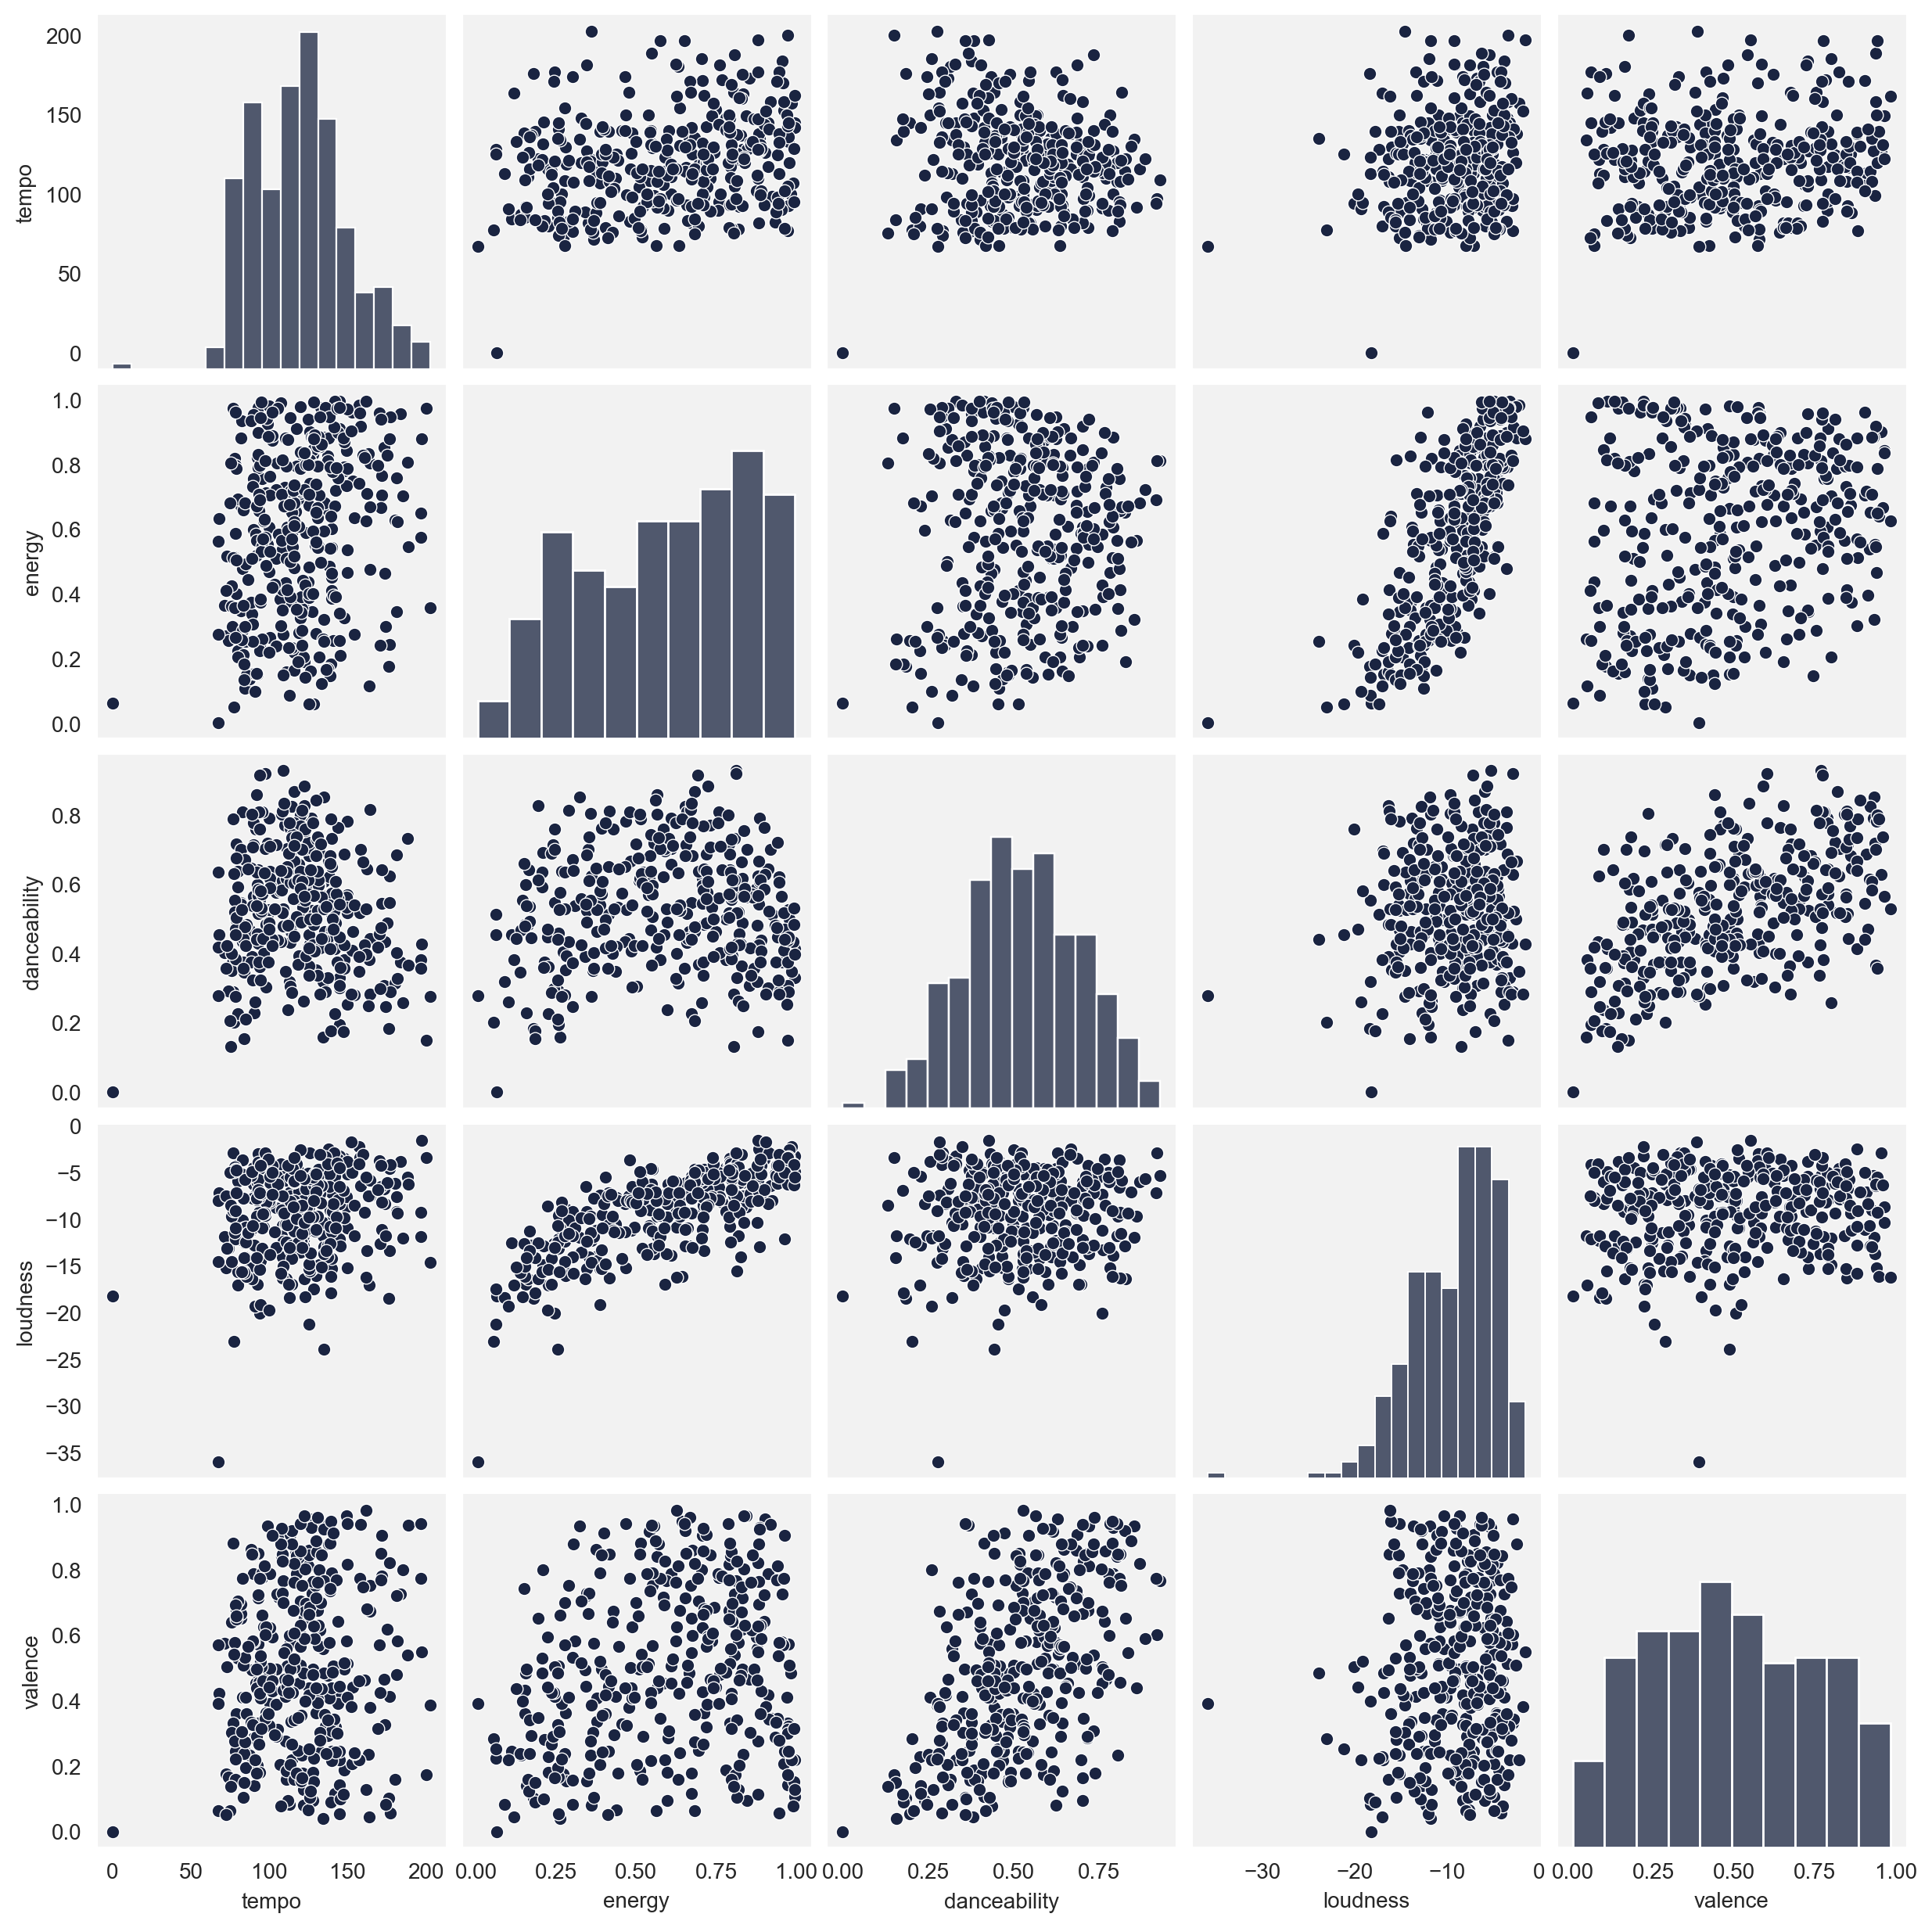

In [6]:
# Pairplot
atr_cols = ["tempo", "energy", "danceability", "loudness", "valence"]
sns.pairplot(df1[atr_cols])

plt.tight_layout;
plt.savefig('pairplot.png', bbox_inches='tight')


All feature values have a natural, normal distribution. Some features seem to be correlated, but it's difficult to say from the scatter plots.



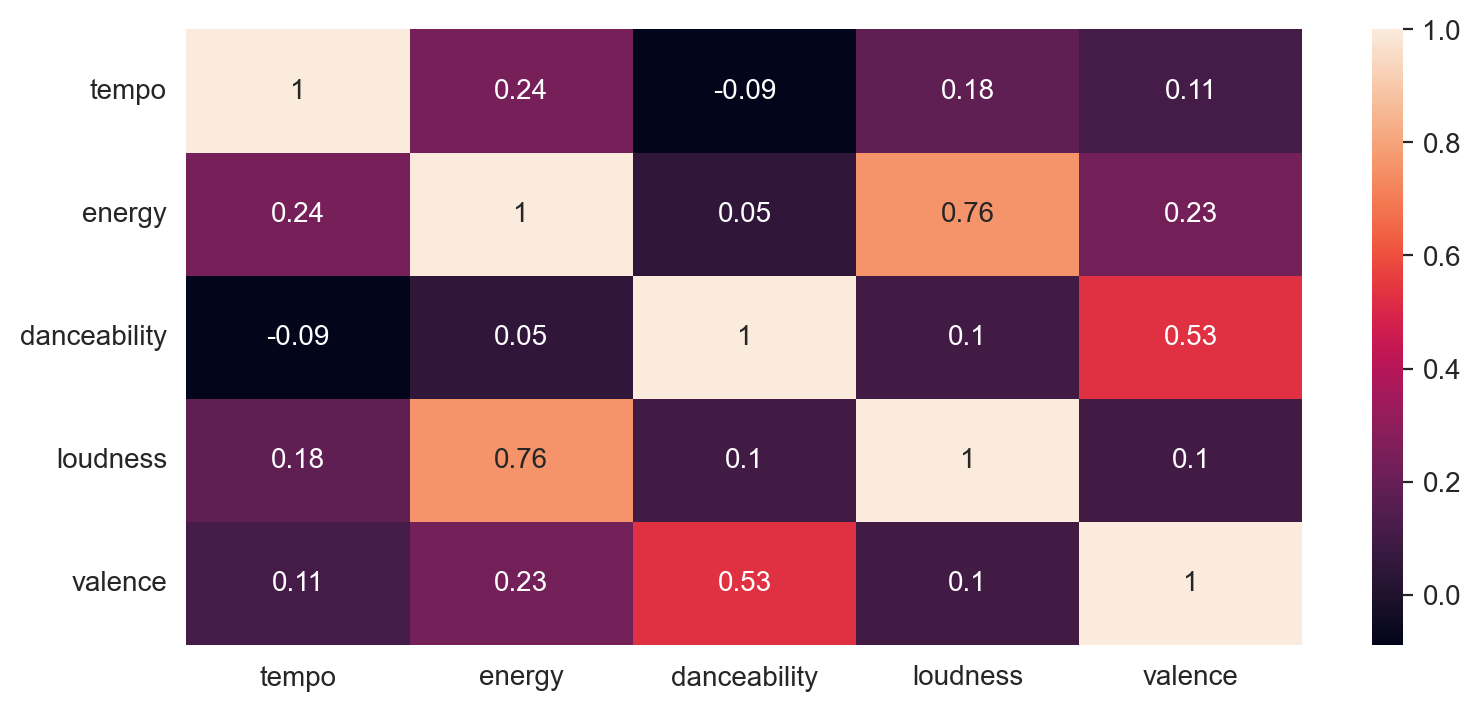

In [7]:
# Correlation matrix
corr_matrix = df1[atr_cols].corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.savefig('correlation.png')

plt.show()


The target feature, valence, is mostly correlated with with danceability and energy, although not significant enough to derive one from the other.


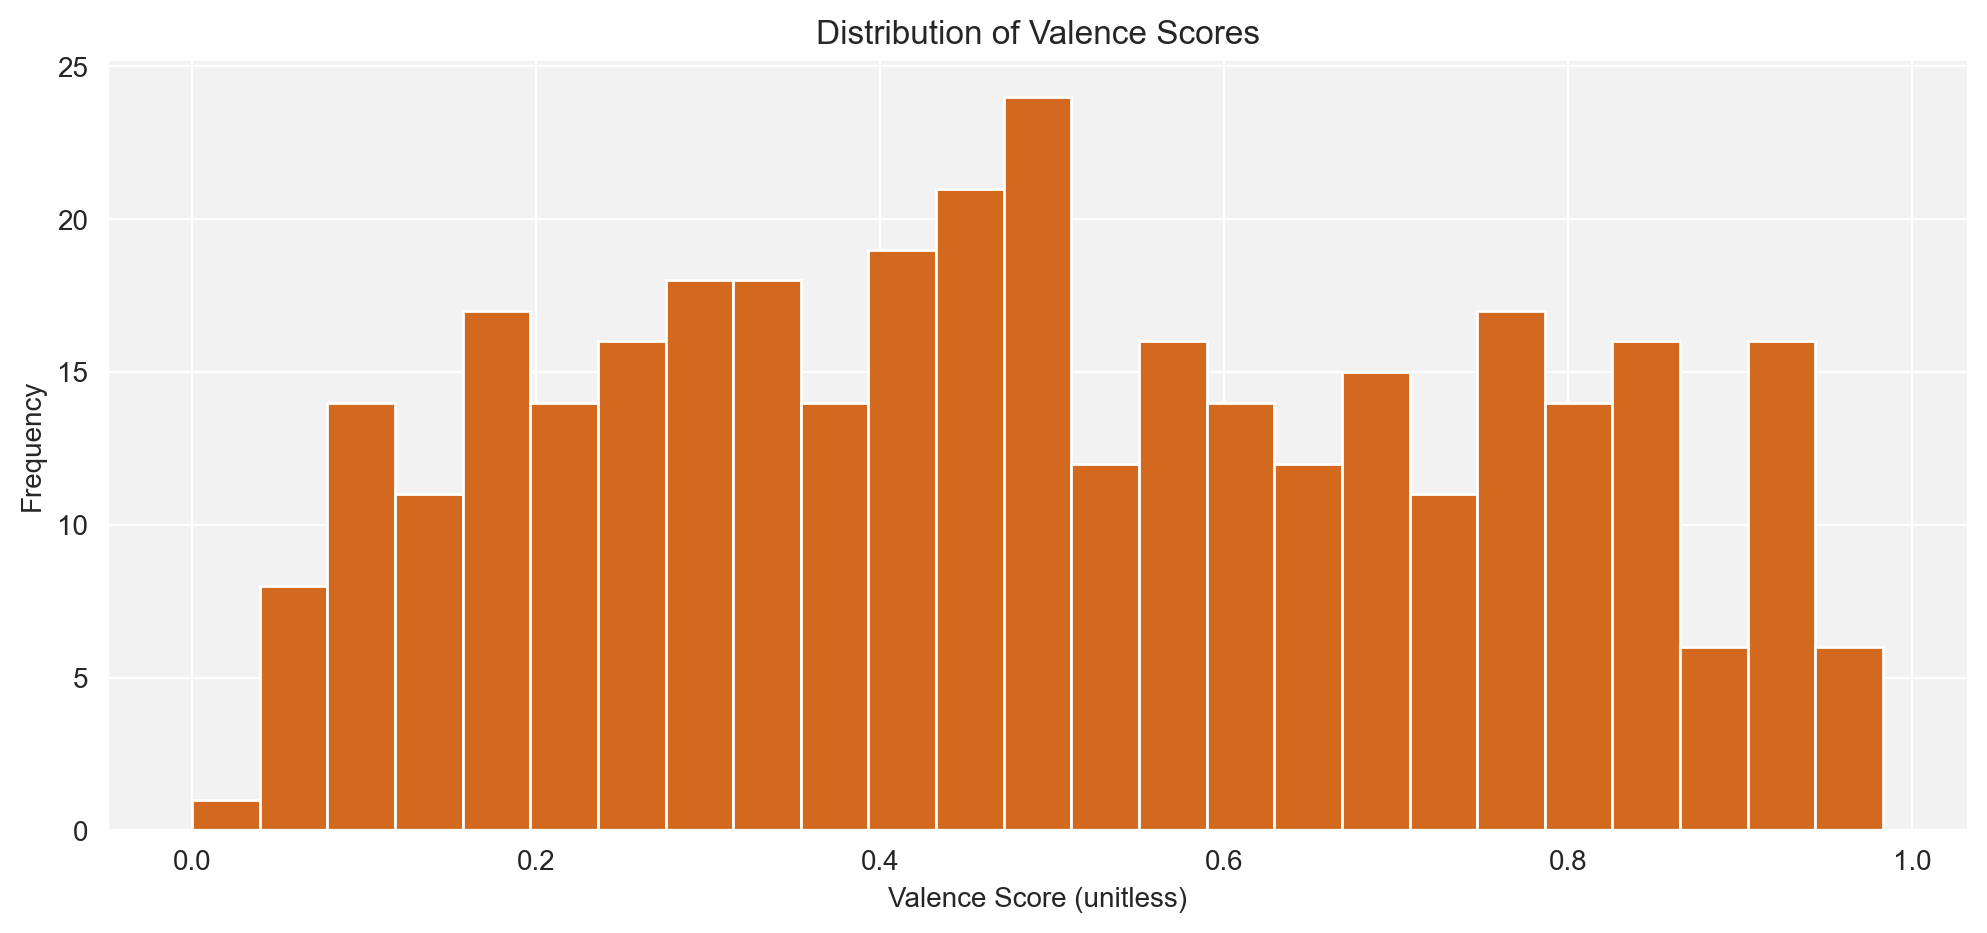

In [8]:
# Distribution of songs' valence score (unitless)
df1.hist(['valence'],bins=25, figsize=(12,5), color='chocolate')
plt.title('Distribution of Valence Scores')
plt.xlabel('Valence Score (unitless)')
plt.ylabel('Frequency')
plt.plot()
plt.savefig('valence.png', bbox_inches='tight')


### Genres

In [9]:
df1.genre.tolist()

['alternative pop',
 'dub',
 'pop',
 'album rock',
 'contemporary country',
 'jam band',
 'jazz blues',
 'alternative hip hop',
 'dance pop',
 'adult standards',
 'lilith',
 'atl hip hop',
 'comic',
 'baroque pop',
 'epicore',
 'alternative metal',
 'austin singer-songwriter',
 'conscious hip hop',
 'australian pop',
 'folk',
 'glam rock',
 'alternative metal',
 'album rock',
 'acoustic pop',
 'classic uk pop',
 'adult standards',
 'alternative metal',
 'bakersfield sound',
 'adult standards',
 'heartland rock',
 'adult standards',
 'canadian pop',
 'east coast hip hop',
 'art rock',
 'classic country pop',
 'anti-folk',
 'country',
 'adult standards',
 'g funk',
 'ccm',
 'canadian metal',
 'adult standards',
 'hardcore hip hop',
 'colombian pop',
 'classic schlager',
 'contemporary country',
 'adult standards',
 'mellow gold',
 'alternative metal',
 'celtic punk',
 'contemporary country',
 'british soul',
 'chicano rap',
 'melodic hardcore',
 'arizona punk',
 'dance pop',
 'alternativ

In [10]:
# Categorize genres using nltk
english_stemmer = SnowballStemmer('english')

def categorize(genre):
    for word in genre.split(' '):
        stem = english_stemmer.stem(word)
        if stem == 'countri':
            return "country"
        if stem == 'hip' or stem =='rap' or stem =='r&b' or stem == "drill":
            return 'hiphop/r&b'
        if stem == 'pop':
            return 'pop'
        if stem == 'rock' or stem == 'metal' or stem == 'punk':
            return 'rock'
        
    
    return 'other'


df1['genre'] = df1['genre'].apply(categorize)



In [11]:
df1.genre.value_counts()

other         151
rock           96
pop            42
hiphop/r&b     32
country        29
Name: genre, dtype: int64

In [12]:
df1.genre.unique().tolist()

['pop', 'other', 'rock', 'country', 'hiphop/r&b']

Unique genres in the dataset:  5



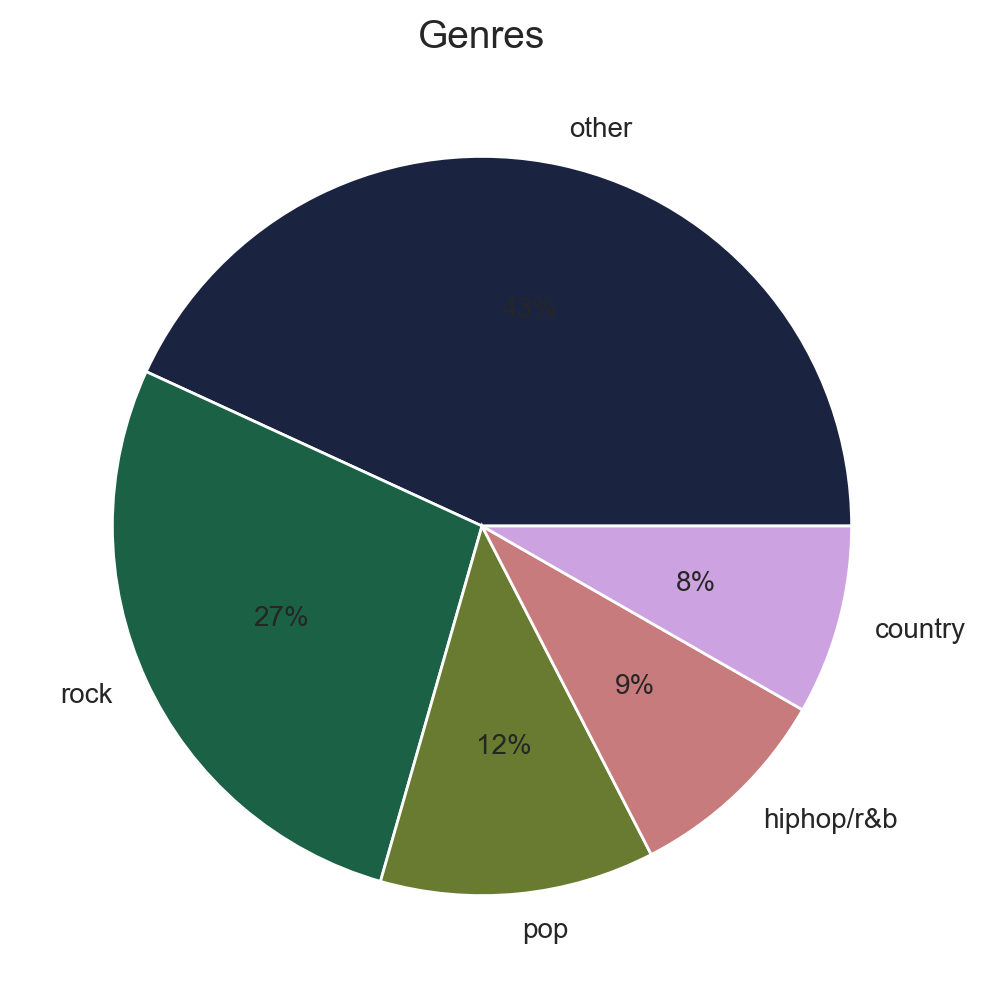

In [13]:
nunique_genres = df1["genre"].nunique()
print("Unique genres in the dataset:  {}\n".format(nunique_genres))

# select the top 10
top10_genres = df1["genre"].value_counts()

# plot a pie chart with genres ratio
plt.figure(figsize=(6, 6))
labels = top10_genres.index
plt.pie(top10_genres, labels=labels,autopct='%1.0f%%')
plt.title("Genres", fontsize=14)
plt.savefig('piechart.png', bbox_inches='tight')

plt.show()



The data sample contains a variety of music genres.  The top genres are Pop, Hip-Hop, Rock, and Country.



### Conclusion
-  The most correlated features are danceability and energy.
- Similar genres grouped and categorized using SnowballStemmer
- The top genres are Pop, Hip-Hop, Rock, and Country.

## Audio Features

Extract audio features from downloaded audio files using the librosa library.


Sampling rate: 22050
index                                                         278
artist                                                Frank Ocean
lyrics          Taxi driver You're my shrink for the hour Leav...
song                                                 Bad Religion
valence                                                     0.104
artist_uri                  spotify:artist:2h93pZq0e7k5yf4dywlkpM
song_id                                    2pMPWE7PJH1PizfgGRMnR9
song_URI                     spotify:track:2pMPWE7PJH1PizfgGRMnR9
preview_url     https://p.scdn.co/mp3-preview/64a52bff39bccded...
genre                                                  hiphop/r&b
tempo                                                      83.331
energy                                                      0.367
danceability                                                0.359
loudness                                                   -7.684
file_name                              2pMPWE7PJH1Pizfg

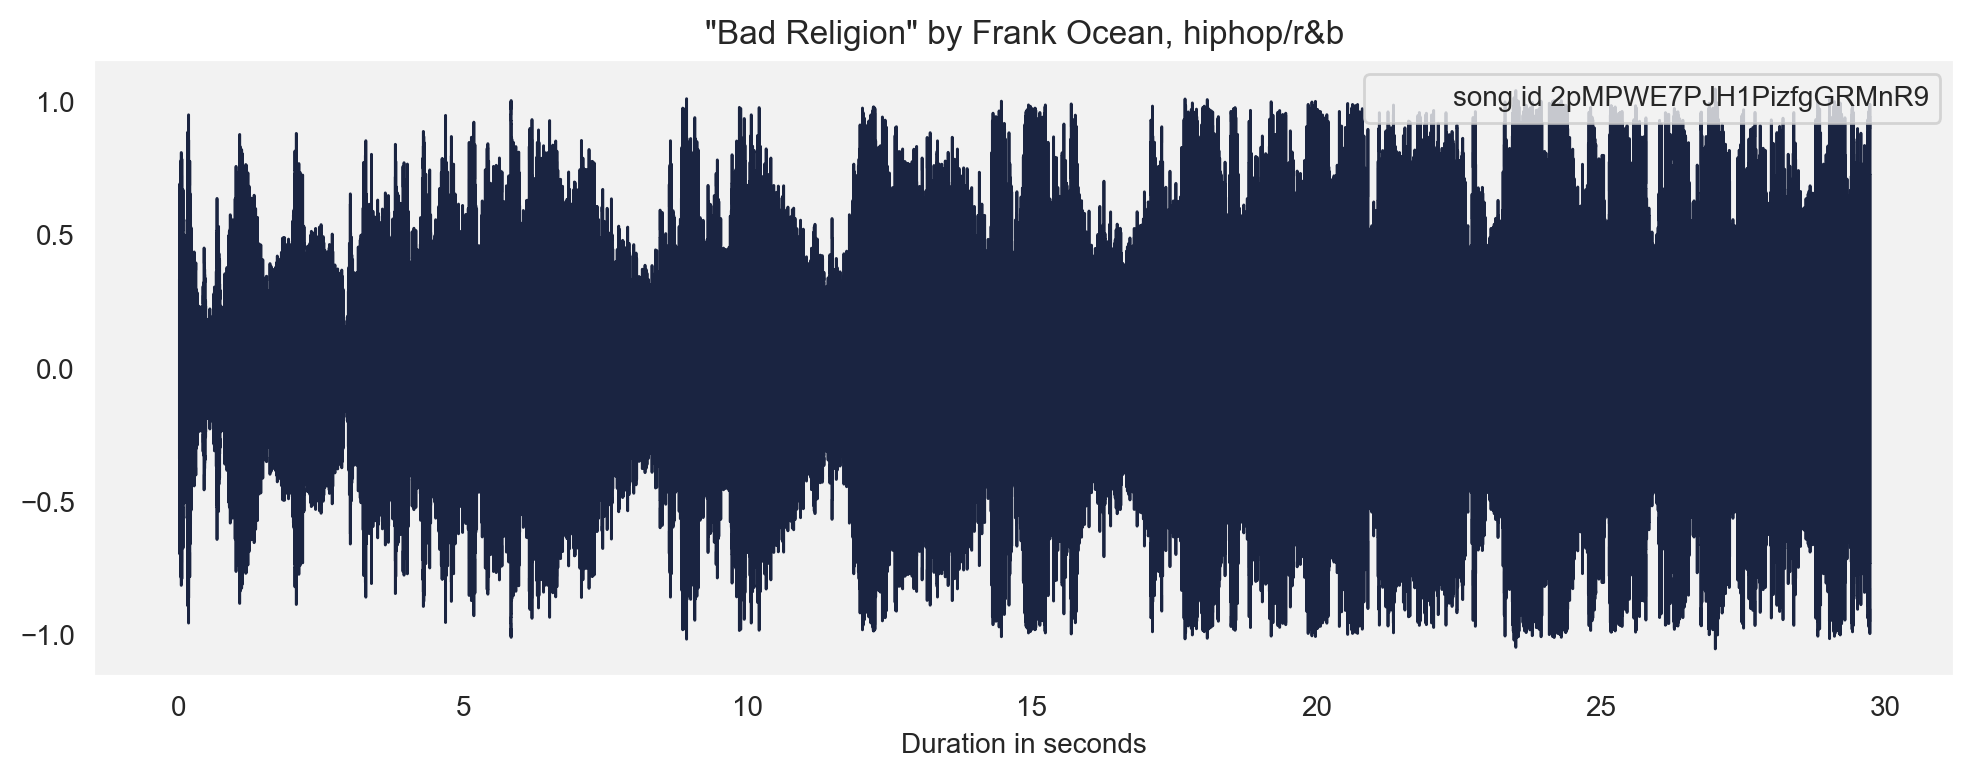

In [14]:
random_idx = np.random.randint(0, df1.shape[0])

# select a random song from the dataset
song = df1.loc[random_idx, :]

# load the file and print its sampling rate 
file_path = f"/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/"
file_path = file_path  + song["file_name"]
audio, sample_rate = librosa.load(file_path)
# print info about this song
print(f"Sampling rate: {sample_rate}")
print(song)

# plot the wavefrom
plt.figure(figsize=(12,4))
ld.waveshow(audio, sr=sample_rate) # plot a waveform and play the file
plt.title(f'"{song.song}" by {song.artist}, {song.genre}')
plt.legend([f"song id {song.song_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

### Mel Spectrograms
A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time.

1.  It uses the Mel Scale instead of Frequency on the y-axis.
2. It uses the Decibel Scale instead of Amplitude to indicate colors.


In [68]:
# load the audio file and resample
y, sr = librosa.load(file_path, duration=30, mono=True)
y = librosa.resample(y, orig_sr=sr, target_sr=16000)

# normalize from -1 to 1
y = librosa.util.normalize(y)

# obtain melspectogram with 80 freq. bins
mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=80)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

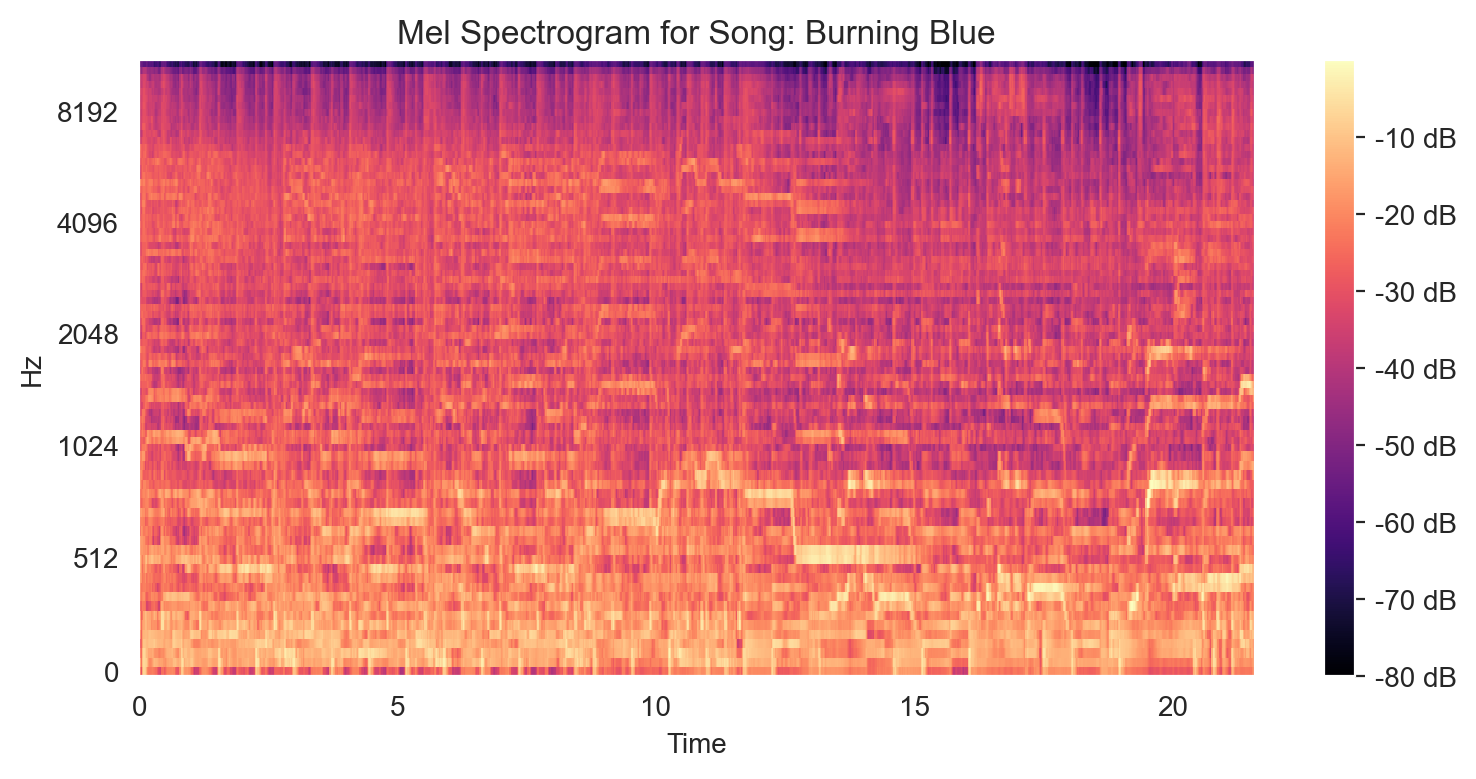

In [70]:
# show the resulting spectogram
librosa.display.specshow(mel_spec, y_axis='mel', x_axis='time')
plt.title("Mel Spectrogram for Song: {}".format(song.song));
plt.colorbar(format='%+2.0f dB');
plt.savefig('melspec.png',bbox_inches='tight')

### Spectral Centroid

Spectral centroid is a measure used in audio processing that indicates the "center of gravity" of the spectrum of a sound. It is calculated by taking the weighted mean of the frequencies present in a sound, with their magnitudes as the weights. It is commonly used to give an impression of the tonal character of a sound, as it is sensitive to the harmonic balance of the sound.

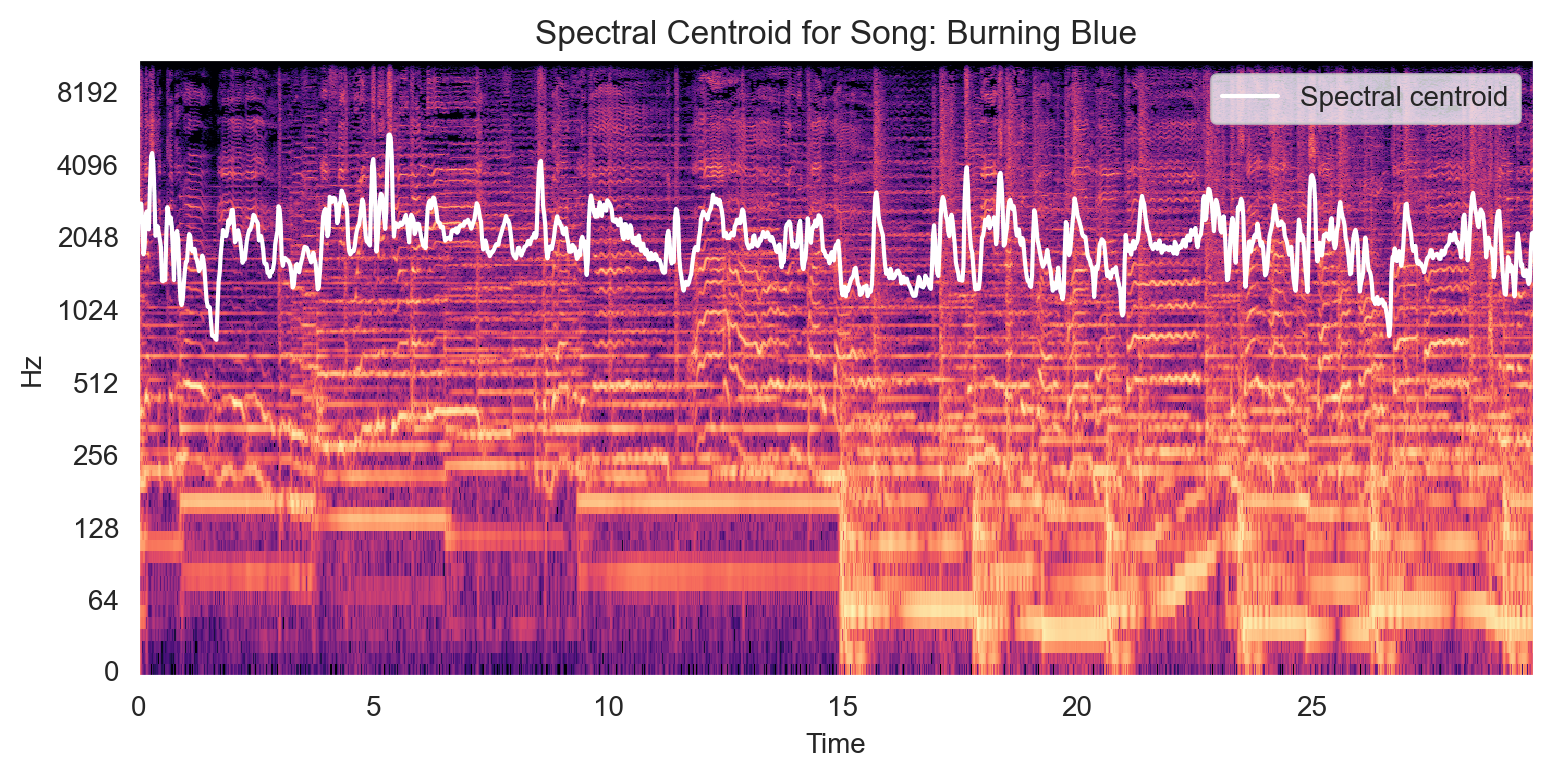

In [66]:

# derive the feature from the audio file
centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)

# obtain other data for plotting
S, phase = librosa.magphase(librosa.stft(y=audio))
times = librosa.times_like(centroid)

fig, ax = plt.subplots()
ax.set(title=f"Spectral Centroid for Song: {song.song}")

# show spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis="log", x_axis="time", ax=ax)
# plot spectral centroid
ax.plot(times, centroid.T, label="Spectral centroid",  color="w")
ax.legend(loc="upper right");
plt.savefig('sp_centroid.png')



### Spectral Rolloff

Spectral rolloff is a feature which measures how quickly the power of a signal decreases as the frequency increases. It can be used to identify the tonal components of a signal and detect the presence of harmonic content.



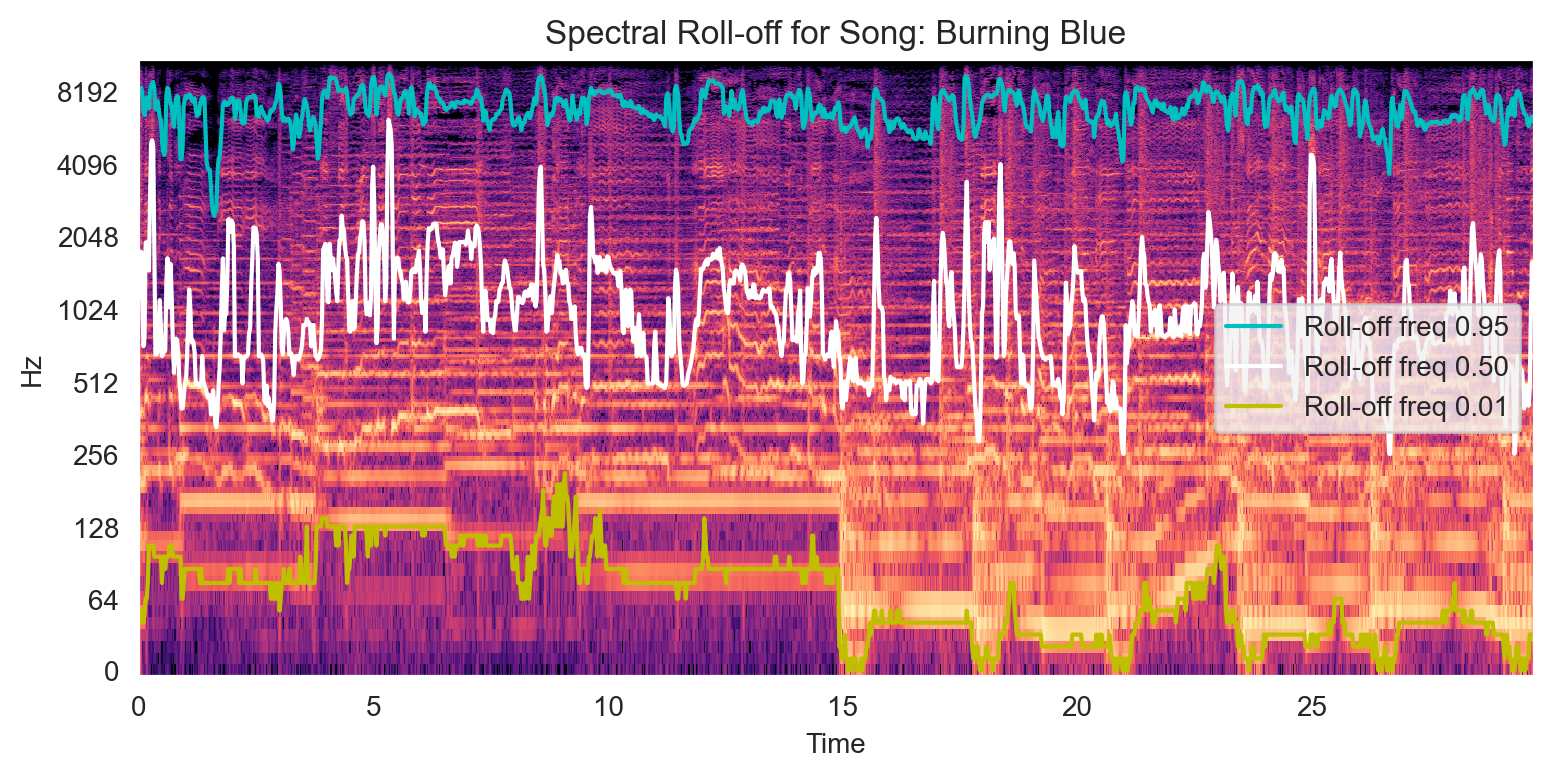

In [67]:
# approximate minimum frequencies with roll_percent=0.95
rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.95)
# approximate minimum frequencies with roll_percent=0.50
rolloff_middle = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.5)
# approximate minimum frequencies with roll_percent=0.01
rolloff_min = librosa.feature.spectral_rolloff(y=audio, sr=sample_rate, roll_percent=0.01)

S, phase = librosa.magphase(librosa.stft(audio))

fig, ax = plt.subplots()
ax.set(title=f"Spectral Roll-off for Song: {song.song}")

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis="log", x_axis="time", ax=ax)

ax.plot(librosa.times_like(rolloff), rolloff[0], label="Roll-off freq 0.95", color="c")
ax.plot(librosa.times_like(rolloff), rolloff_middle[0], label="Roll-off freq 0.50", color="w")
ax.plot(librosa.times_like(rolloff), rolloff_min[0], label="Roll-off freq 0.01", color="y")
ax.legend(loc='center right');
plt.savefig('sp_rolloff.png')


### Spectral Contrast

Spectral contrast, as implemented in the librosa library, is used to highlight the differences in frequency content of a signal, and can be used to detect and identify individual instruments, as well as providing general information about the signal. The process of spectral contrast works by measuring the overall average energy of each frequency band, then subtracting this average from the original signal. This reveals the differences in the signal which would otherwise be difficult to detect. By doing this, spectral contrast can provide an understanding of the structure of a sound, and can even be used to detect and identify individual instruments.


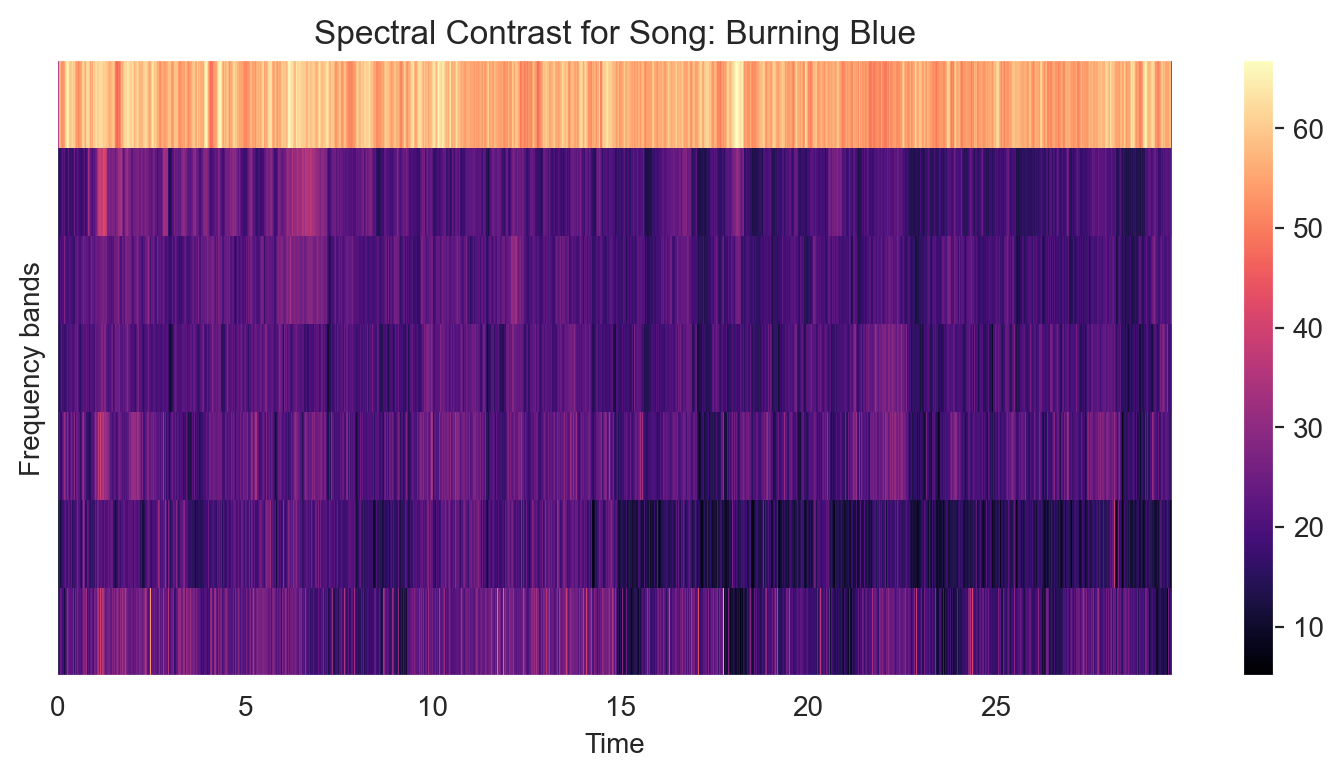

In [71]:
S = np.abs(librosa.stft(y=audio))
contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate, n_bands=6)

fig, ax = plt.subplots()

# plot spectral contrast
img2 = librosa.display.specshow(contrast, x_axis="time", ax=ax)
fig.colorbar(img2, ax=ax)
ax.set(ylabel="Frequency bands", title=f"Spectral Contrast for Song: {song.song}");
plt.savefig('sp_contrast.png')



### Mel-Frequency Cepstrum Coefficients
MEL-Frequency Cepstrum Coefficients (MFCCs) is a powerful technique for recognizing patterns in audio signals. It used to represent audio signals in a form that is more easily analyzed by machines. MFCCs are derived from a Fourier transform and are used in speech and music recognition applications.

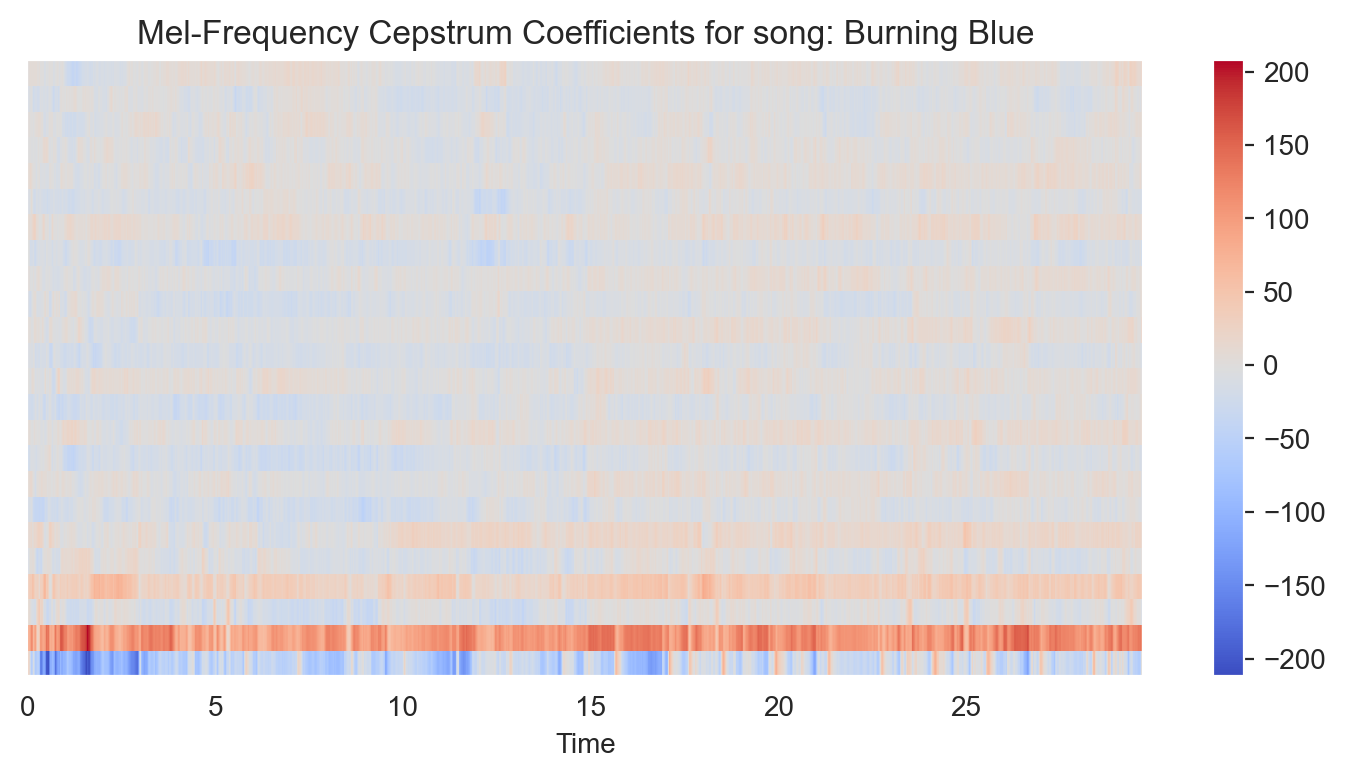

In [72]:
# generate mfccs from the audio file
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=24)

fig, ax = plt.subplots()

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title=f"Mel-Frequency Cepstrum Coefficients for song: {song.song}");

plt.savefig('mfcc.png')



### Zero Crossing Rate
The Zero Crossing Rate (ZCR) is a measure used in signal processing to identify the number of times a signal crosses the zero axis. It is often used to analyze audio signals, as it can provide an indication of the perceptual loudness of the audio. ZCR can be calculated by counting the number of times the signal crosses the zero axis in a given time interval.



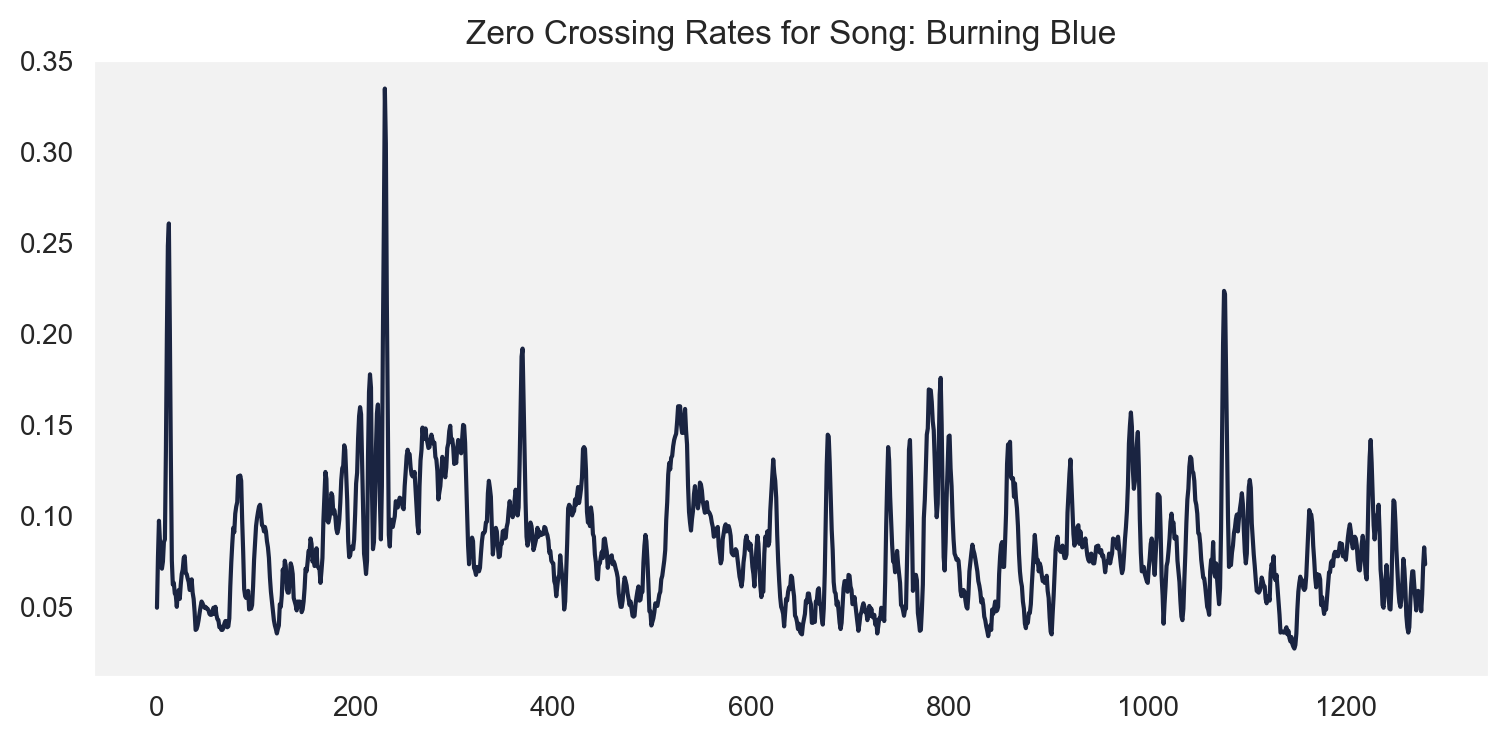

In [73]:
zcrs = librosa.feature.zero_crossing_rate(audio)

plt.plot(zcrs[0])
plt.title(f"Zero Crossing Rates for Song: {song.song}");
plt.savefig('zcr.png')


### Chroma Energy Normalized Statistics (CENS)


Chroma CENS Librosa is a set of audio features used for music/speech analysis. It is based on the Short-Time Fourier Transform and is used to extract a 12-dimensional feature vector from an audio signal. The vector encodes the harmonic content of the signal and is designed to be invariant to changes in tempo. The feature vector is then used for tasks such as music/speech recognition and classification.

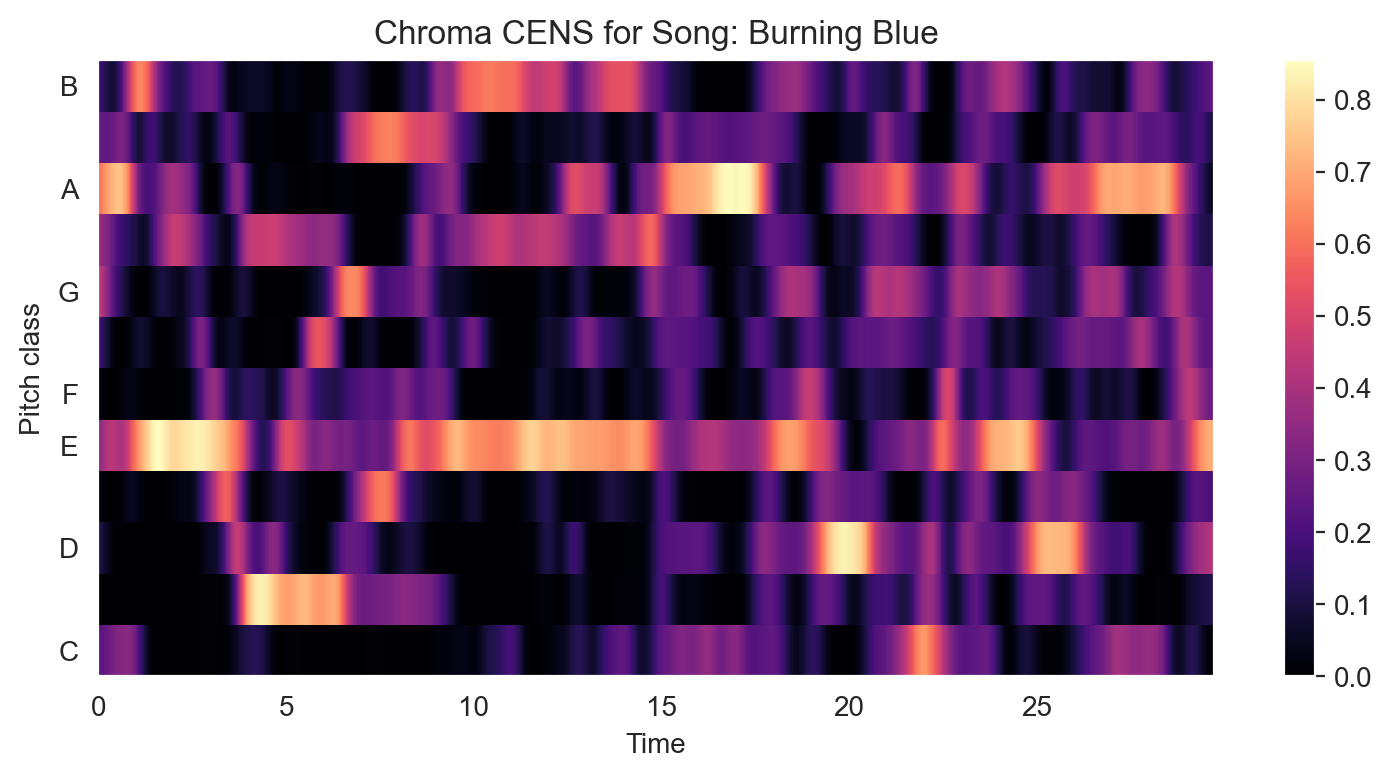

In [77]:
chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sample_rate)

fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_cens, y_axis="chroma", x_axis="time")
fig.colorbar(img)
ax.set(title=f"Chroma CENS for Song: {song.song}");
plt.savefig('chromacens.png')


### Beats per Minute (BPM)

The tempo of a song can be defined as its speed, or how quickly the music moves. It can range from slow and gentle to fast and intense, depending on the genre and style of the music. In a dynamic tempo, the speed of the music changes throughout the song, creating a sense of excitement and anticipation. This can be done by increasing the tempo gradually or by sudden changes in speed.

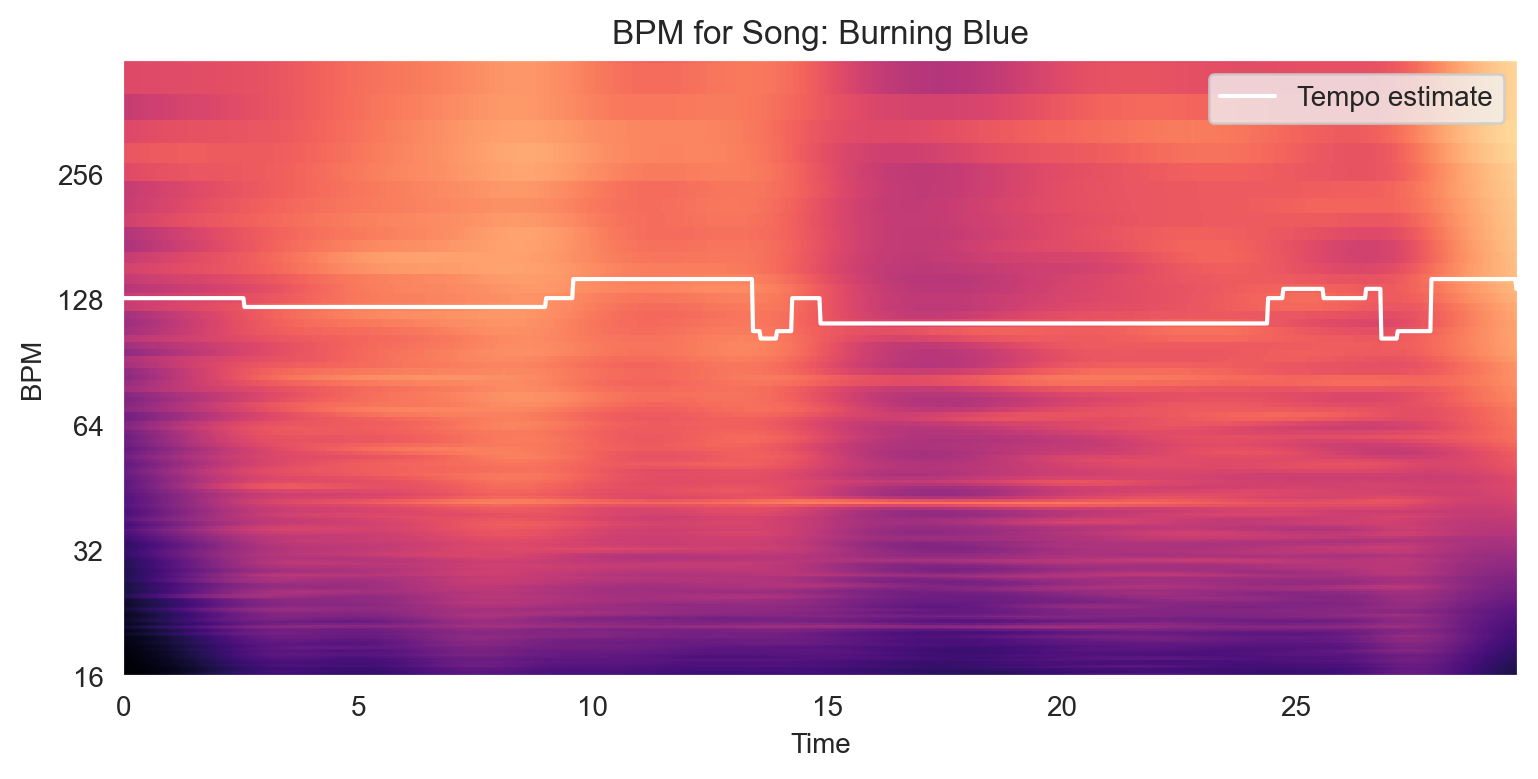

In [78]:
onset_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate, aggregate=None)

fig, ax = plt.subplots()
tg = librosa.feature.tempogram(onset_envelope=onset_env, sr=sample_rate, hop_length=512)
librosa.display.specshow(tg, x_axis="time", y_axis="tempo", cmap="magma", ax=ax)

ax.plot(librosa.times_like(dtempo), dtempo, color="w", linewidth=1.5, label="Tempo estimate")

ax.set(title=f"BPM for Song: {song.song}")
ax.legend();
plt.savefig('bpm.png')


### Root Mean Square (RMS)

RMS is a measure of the average power of a signal over time. It is useful for comparing the loudness of different audio signals, as well as for analyzing the spectral content of signals.

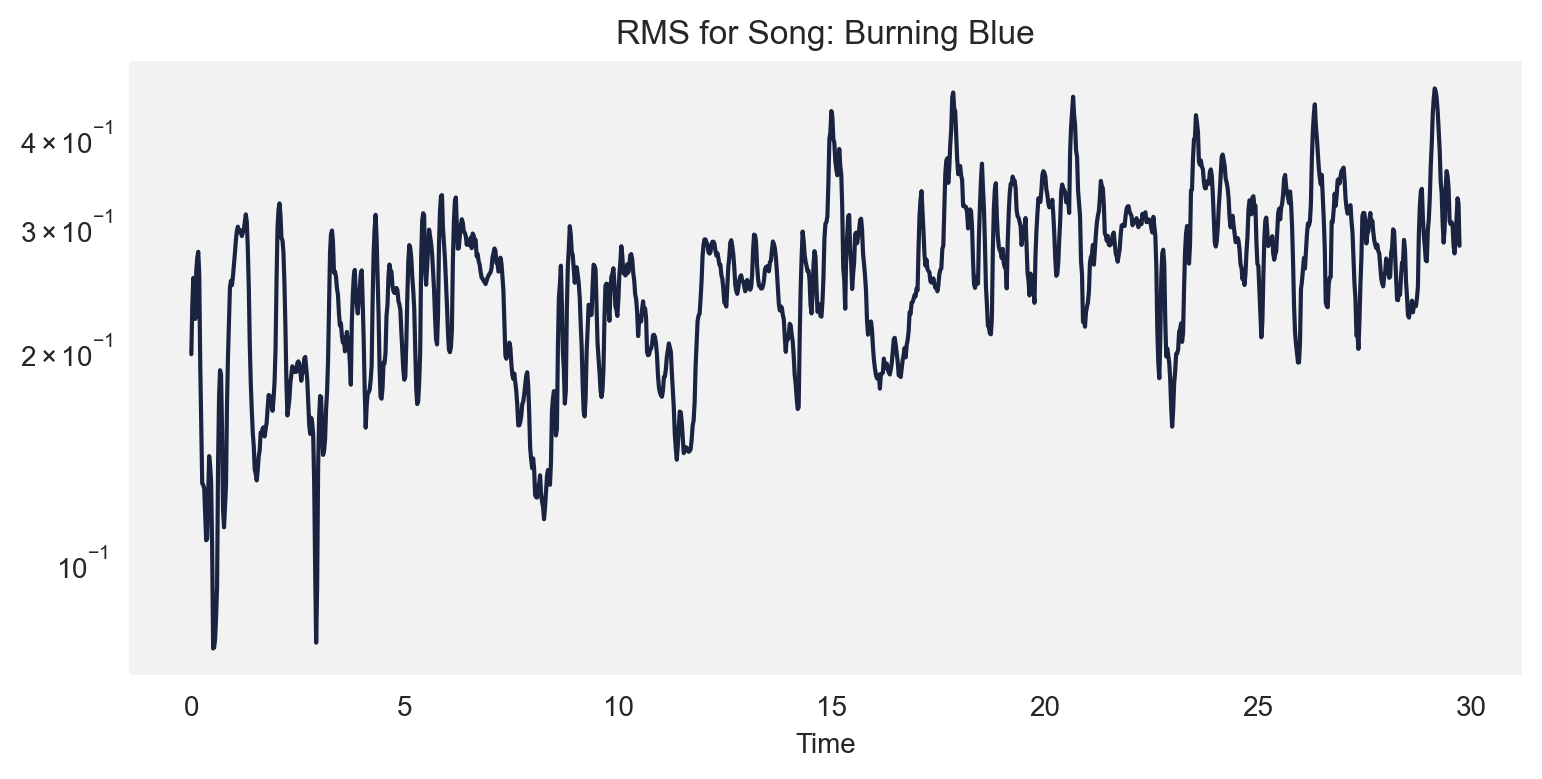

In [76]:
rms = librosa.feature.rms(y=audio)[0]

fig, ax = plt.subplots()
times = librosa.times_like(rms)
ax.set(title=f"RMS for Song: {song.song}", xlabel="Time")
ax.semilogy(times, rms, label='RMS Energy');
plt.savefig('rootmeansq.png')


## Machine Learning

### Feature Extraction

Before training models, input audio needs to be processed and converted into a numeric representation.

In [25]:
# Feature extraction functions
def get_stats(array):
    """
    Calculates the mean, variance, minimum and maximum values of an array.
    """
    if len(array.shape) > 1:
        feature = np.concatenate(
            (
                np.mean(array, axis=1),
                np.var(array, axis=1),
                np.min(array, axis=1),
                np.max(array, axis=1),
            )
        )
    else:
        feature = np.array(
            (np.mean(array), np.var(array), np.min(array), np.max(array))
        )
    return feature

def get_features(file_path, duration=25):
    """
    Extracts features from an audio file.
    """
    y, sr = librosa.load(file_path, duration=duration)
    
    # Mel Spectogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=80)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    melspec_features = get_stats(mel_spec)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=24)
    mfccs_features = get_stats(mfccs)
    
    # Spectral Centroid

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_features = get_stats(cent)
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)
    rolloff_middle = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.5)
    rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)
    rolloff_features = np.concatenate(
        (get_stats(rolloff), get_stats(rolloff_middle), get_stats(rolloff_min))
    )
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y=y)), sr=sr)
    contrast_features = get_stats(contrast)
    
    # CENS
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    chroma_cens_features = get_stats(chroma_cens)

    # BPM
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)
    dtempo_features = get_stats(dtempo)

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_features = get_stats(zcr)
    
    # RMS
    rms = librosa.feature.rms(y=y)[0]
    rms_features = get_stats(rms)

    features = np.concatenate(
        (
            melspec_features,
            mfccs_features,
            cent_features,
            rolloff_features,
            contrast_features,
            chroma_cens_features,
            dtempo_features,
            zcr_features,
            rms_features,
        )
    )

    return features


In [26]:
# Model evaluation function
def eval_model(model, X, y, print_metrics=True):
    """
    Trains a model using cross-validation and returns average metrics.
    
    """
    try:
        scores = cross_validate(
        model, X, y, cv=5, n_jobs=-1, scoring=("r2","neg_mean_absolute_error")
        )
        r2 = np.average(scores["test_r2"])
        mae = abs(np.average(scores["test_neg_mean_absolute_error"]))
        fit_time = np.average(scores["fit_time"])
        score_time = np.average(scores["score_time"])

        if print_metrics == True:
            print("Fit time: {:.5f}".format(fit_time))
            print("Score time: {:.5f}".format(score_time))
            print("R^2: {:.4f}".format(r2))
            print("MAE {:.4f}".format(mae))
        else:
            return r2,mae
    except:
        pass

In [27]:
# test if the functions work
features = np.array([])
n = 10

for i in tqdm(range(n)):
    file_path = df1.loc[i, "file_path"]
    features = np.append(features, get_features(file_path), axis=0)

features = features.reshape(n, 520)
features.shape

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


(10, 520)

In [28]:
df1

index                 artist  \
0        0        Letters to Cleo   
1        1         Gregory Isaacs   
2        2                  HONNE   
3        3           Richard Marx   
4        4       Billy Currington   
..     ...                    ...   
345    382         Rachel Stevens   
346    383               Megadeth   
347    384           The Supremes   
348    385  Ramblin' Jack Elliott   
349    386        Ella Fitzgerald   

                                                lyrics  \
0    The saddest sound I've ever heard; the saddest...   
1    I thought it would be better  Now I'm a brande...   
2    Ten out of ten  You killed it once again  'Cau...   
3    We're all victims of the system  Still we love...   
4    Hey, girl, what's your name, girl I've been lo...   
..                                                 ...   
345  Yeah    You got the time, I got the money  We'...   
346  I barely get to the graveyard shift on time  A...   
347  For your lovin', oh, oh, yeah  Oh, oh, yeah, w...   
348  It was early springtime that the strike was on...   
349  We're going through the impatient years  The y...   

                        song  valence                             artist_uri  \
0                     Wasted    0.465  spotify:artist:7E41j1yL9ZeTWfqe9bUGgw   
1                Hot Stepper    0.934  spotify:artist:6QHu71f8LLeT8n0GzfbYFc   
2                      Woman    0.246  spotify:artist:0Vw76uk7P8yVtTClWyOhac   
3       Hands in Your Pocket    0.789  spotify:artist:0grdhNhiRLFBaFVyybqsj6   
4                   Hey Girl    0.652  spotify:artist:1By9QBFnjZAoI83BZppHlt   
..                       ...      ...                                    ...   
345          I Got the Money    0.848  spotify:artist:7LP4hiTAVkw3Rtc1hqtLi4   
346   The Right to Go Insane    0.538  spotify:artist:1Yox196W7bzVNZI7RBaPnf   
347  It's Time to Break Down    0.942  spotify:artist:57bUPid8xztkieZfS7OlEV   
348          Ludlow Massacre    0.498  spotify:artist:6iuM8yp1x2N0l6SONhyq4b   
349      The Impatient Years    0.223  spotify:artist:5V0MlUE1Bft0mbLlND7FJz   

                    song_id                              song_URI  \
0    1hUkQE51UrZfq7XxqFDkv9  spotify:track:1hUkQE51UrZfq7XxqFDkv9   
1    5S0lcuJlVSUrhC3AuuZNwY  spotify:track:5S0lcuJlVSUrhC3AuuZNwY   
2    6YpSiNQN8pVzJMOX2fXGHm  spotify:track:6YpSiNQN8pVzJMOX2fXGHm   
3    2uTpWrFRBfeXHq7DtrSzFq  spotify:track:2uTpWrFRBfeXHq7DtrSzFq   
4    4CcrLWFQY4dRGMbUR59cSp  spotify:track:4CcrLWFQY4dRGMbUR59cSp   
..                      ...                                   ...   
345  5Vira9mKFgZReabMPhNNhF  spotify:track:5Vira9mKFgZReabMPhNNhF   
346  5bILDCXPGi8U8rgfS75gbo  spotify:track:5bILDCXPGi8U8rgfS75gbo   
347  6YQ1iVb2mGvkL5VOB8rwJx  spotify:track:6YQ1iVb2mGvkL5VOB8rwJx   
348  54fqkcCzOzYfvXd80mMkce  spotify:track:54fqkcCzOzYfvXd80mMkce   
349  1jtoAyt8pHl8HLWqr5SDVZ  spotify:track:1jtoAyt8pHl8HLWqr5SDVZ   

                                           preview_url    genre    tempo  \
0    https://p.scdn.co/mp3-preview/a21a04f0773faf75...      pop  173.239   
1    https://p.scdn.co/mp3-preview/3b5534d30d9d4973...    other  134.595   
2    https://p.scdn.co/mp3-preview/b956fbd942363aea...      pop  139.649   
3    https://p.scdn.co/mp3-preview/299f662664d0aae0...     rock  117.146   
4    https://p.scdn.co/mp3-preview/413f5a35ec3269d9...  country   81.947   
..                                                 ...      ...      ...   
345  https://p.scdn.co/mp3-preview/6585f854dbab1637...    other   88.997   
346  https://p.scdn.co/mp3-preview/df81f796d28d9f57...     rock   94.135   
347  https://p.scdn.co/mp3-preview/0744f32eb7bfc4d7...    other  196.817   
348  https://p.scdn.co/mp3-preview/f24027d53bd65043...    other   91.828   
349  https://p.scdn.co/mp3-preview/b78b6884c715cf5c...    other   78.358   

     energy  danceability  loudness                   file_name  \
0     0.852         0.309    -6.751  1hUkQE51UrZfq7XxqFDkv9.mp3   
1     0.322         0.854 

In [29]:
# extract features
#features = np.array([])
#n = df1.shape[0]

#for i in tqdm(range(n)):
#     file_path = df1.loc[i, "file_path"]
#     features = np.append(features, get_features(file_path), axis=0)


In [30]:

features = features.reshape(n,520)
features.shape

(10, 520)

In [31]:
# save dataframe with features for further use
#pd.DataFrame(features).to_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/spot_520_features.csv")

In [32]:
spot_features = pd.read_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/spotifyAPI/spot_520_features.csv", index_col=0).values


### Regression

In [33]:
df1.valence.shape

(350,)

In [34]:
spot_features.shape

(350, 520)

In [35]:
X_s = spot_features
y_s = (df1["valence"]).round(3)

# split the data into the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_s, y_s, test_size=0.2, random_state=12345
)



In [36]:
eval_model(RandomForestRegressor(),X_train,y_train)

Fit time: 2.25885
Score time: 0.00364
R^2: 0.3734
MAE 0.1671


In [37]:
eval_model(SVR(), X_train, y_train)

Fit time: 0.01449
Score time: 0.00485
R^2: -0.0114
MAE 0.2126


In [38]:
lgbm = LGBMRegressor(random_state=12345)
eval_model(lgbm, X_train, y_train)

Fit time: 0.23366
Score time: 0.00199
R^2: 0.3241
MAE 0.1689


In [39]:
xgb = XGBRegressor(random_state=12345)
eval_model(xgb, X_train, y_train)

Fit time: 0.63617
Score time: 0.00133
R^2: 0.2719
MAE 0.1746


In [40]:
%%time
params = dict(
    n_estimators=(100, 200, 300),
    max_depth=(2,4,6)
)

rf = RandomForestRegressor( verbose=0)

grid = GridSearchCV(
    rf, param_grid=params, n_jobs=-1, scoring="r2"
)
grid_result = grid.fit(X_train, y_train)

print(
    "Best R2: {:.4f} \nUsing params:\n{}".format(
        grid_result.best_score_, grid_result.best_params_
    )
)

Best R2: 0.3784 
Using params:
{'max_depth': 6, 'n_estimators': 300}
CPU times: user 5.83 s, sys: 32.2 ms, total: 5.86 s
Wall time: 25.3 s


In [41]:
rf = RandomForestRegressor(max_depth=4,n_estimators=300,
     verbose=0
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R^2: {:.4f}".format(r2))
print("MAE: {:.4f}".format(mae))

R^2: 0.1961
MAE: 0.1831


In [42]:
model_spot = RandomForestRegressor(max_depth=4,n_estimators=300,
     verbose=0).fit(X_s, y_s)


In [88]:
# Get predictions
pred_table = pd.DataFrame()
np.random.seed(12345)

for i in tqdm(range(50)):
    idx = np.random.randint(0, 350)
    song = df1.loc[idx, :]

    pred_table.loc[i, "song"] = song["song"]
    pred_table.loc[i, "artist"] = song["artist"]
    pred_table.loc[i, "song_preview_url"] = song["preview_url"]
    pred_table.loc[i, "valence"] = song["valence"]
    file_path = df1.loc[idx, "file_path"]
    features = get_features(song.file_path)
    spot_pred = model_spot.predict(features.reshape(1,520)).round(2)[0]

    pred_table.loc[i, "valence_prediction"] = spot_pred

    print(
        f"{song.song[:20]:20s} --> valence prediction: {spot_pred}\nurl: {song.preview_url}\n"
    )


  2%|▉                                           | 1/50 [00:01<00:49,  1.00s/it]

Everybody's Talkin'  --> valence prediction: 0.25
url: https://p.scdn.co/mp3-preview/6b3bb5ccee7ca99b9466bf6514daf273336d8717?cid=851724c9cd454f1ca279898a01ba1edd



  4%|█▊                                          | 2/50 [00:01<00:47,  1.02it/s]

June Night           --> valence prediction: 0.43
url: https://p.scdn.co/mp3-preview/281d4147a81173ab3b93a61fc20ed0407dcc437b?cid=851724c9cd454f1ca279898a01ba1edd



  6%|██▋                                         | 3/50 [00:02<00:46,  1.02it/s]

Maggie               --> valence prediction: 0.35
url: https://p.scdn.co/mp3-preview/3aeac8c72e1f30a98f9c428d1cf2e206e4a467c3?cid=851724c9cd454f1ca279898a01ba1edd



  8%|███▌                                        | 4/50 [00:03<00:45,  1.02it/s]

The Patient Ferris W --> valence prediction: 0.51
url: https://p.scdn.co/mp3-preview/257572f0331d02aa110dc4644f4440bde365b994?cid=851724c9cd454f1ca279898a01ba1edd



 10%|████▍                                       | 5/50 [00:04<00:45,  1.01s/it]

Do You Think I Am Se --> valence prediction: 0.69
url: https://p.scdn.co/mp3-preview/d32b1dcf3e96209afeb3f0976bbf0acd5a5eba61?cid=851724c9cd454f1ca279898a01ba1edd



 12%|█████▎                                      | 6/50 [00:05<00:44,  1.00s/it]

Rational Gaze        --> valence prediction: 0.3
url: https://p.scdn.co/mp3-preview/c005ce19873db74d4386295a8f608b6b11c7fdb5?cid=851724c9cd454f1ca279898a01ba1edd



 14%|██████▏                                     | 7/50 [00:06<00:43,  1.01s/it]

Cheatin' Woman       --> valence prediction: 0.6
url: https://p.scdn.co/mp3-preview/7864edbd0fd9df151610c54d2ba082adde20e7c8?cid=851724c9cd454f1ca279898a01ba1edd



 16%|███████                                     | 8/50 [00:08<00:42,  1.02s/it]

Help Me              --> valence prediction: 0.55
url: https://p.scdn.co/mp3-preview/aa72ea848109532018a4b1b94d85c89770a7b268?cid=851724c9cd454f1ca279898a01ba1edd



 18%|███████▉                                    | 9/50 [00:09<00:42,  1.04s/it]

If I Kiss You (Will  --> valence prediction: 0.68
url: https://p.scdn.co/mp3-preview/67d72107aed9053157dc6bbebb9e636b84869f01?cid=851724c9cd454f1ca279898a01ba1edd



 20%|████████▌                                  | 10/50 [00:10<00:40,  1.02s/it]

Morphine Season      --> valence prediction: 0.41
url: https://p.scdn.co/mp3-preview/d73e441a5680929a27b79ed7b12ea36bf0917e86?cid=851724c9cd454f1ca279898a01ba1edd



 22%|█████████▍                                 | 11/50 [00:11<00:39,  1.02s/it]

Believe Me           --> valence prediction: 0.51
url: https://p.scdn.co/mp3-preview/9ea838468978385472783d39a8937bf3ba6b45dd?cid=851724c9cd454f1ca279898a01ba1edd



 24%|██████████▎                                | 12/50 [00:12<00:38,  1.01s/it]

Diana                --> valence prediction: 0.54
url: https://p.scdn.co/mp3-preview/425620cef0d6a8b88598dc2f3dcf6dc44aa91fa6?cid=851724c9cd454f1ca279898a01ba1edd



 26%|███████████▏                               | 13/50 [00:13<00:37,  1.01s/it]

Days of Light        --> valence prediction: 0.7
url: https://p.scdn.co/mp3-preview/57eb3ae16d3ae4f35ff152b66208cb4430b857b3?cid=851724c9cd454f1ca279898a01ba1edd



 28%|████████████                               | 14/50 [00:14<00:36,  1.01s/it]

All Hell's Breakin'  --> valence prediction: 0.63
url: https://p.scdn.co/mp3-preview/6740ba7b1a76969513cb820d913f9948536cf9f9?cid=851724c9cd454f1ca279898a01ba1edd



 30%|████████████▉                              | 15/50 [00:15<00:35,  1.01s/it]

Empty Glass          --> valence prediction: 0.31
url: https://p.scdn.co/mp3-preview/6fb65291df64ae70ee3f34cf462720d6e481a189?cid=851724c9cd454f1ca279898a01ba1edd



 32%|█████████████▊                             | 16/50 [00:16<00:34,  1.01s/it]

Ice on Fire          --> valence prediction: 0.45
url: https://p.scdn.co/mp3-preview/6c337455d0946c26b1000aa4e29498d953e55201?cid=851724c9cd454f1ca279898a01ba1edd



 34%|██████████████▌                            | 17/50 [00:17<00:33,  1.01s/it]

Half Full Dixie Cup  --> valence prediction: 0.64
url: https://p.scdn.co/mp3-preview/7c0f4a22295a839d5f80ea63405ec5df99c05343?cid=851724c9cd454f1ca279898a01ba1edd



 36%|███████████████▍                           | 18/50 [00:18<00:32,  1.00s/it]

Y.O.U.               --> valence prediction: 0.55
url: https://p.scdn.co/mp3-preview/8e4cdda7f60faa1cb48166f3cff5c16ab4f0793f?cid=851724c9cd454f1ca279898a01ba1edd



 38%|████████████████▎                          | 19/50 [00:19<00:31,  1.00s/it]

She Would Die for Lo --> valence prediction: 0.21
url: https://p.scdn.co/mp3-preview/6cc7dd9faab5eb59fb72b305871f79f4f01be9a6?cid=851724c9cd454f1ca279898a01ba1edd



 40%|█████████████████▏                         | 20/50 [00:20<00:30,  1.00s/it]

Burning Blue         --> valence prediction: 0.51
url: https://p.scdn.co/mp3-preview/76e6a14123739d8850adbf3bb12d116276c031e7?cid=851724c9cd454f1ca279898a01ba1edd



 42%|██████████████████                         | 21/50 [00:21<00:29,  1.00s/it]

Oropel               --> valence prediction: 0.45
url: https://p.scdn.co/mp3-preview/6200c37317c0e239e7e0d0ca31695d923e80b57b?cid=851724c9cd454f1ca279898a01ba1edd



 44%|██████████████████▉                        | 22/50 [00:22<00:28,  1.00s/it]

Up to Me             --> valence prediction: 0.66
url: https://p.scdn.co/mp3-preview/db8f1a24b2524c48610ab1e2891e230ac17bad17?cid=851724c9cd454f1ca279898a01ba1edd



 46%|███████████████████▊                       | 23/50 [00:23<00:27,  1.00s/it]

Falling              --> valence prediction: 0.43
url: https://p.scdn.co/mp3-preview/f59be7951c32b441005096c7cdbfac09bf85c393?cid=851724c9cd454f1ca279898a01ba1edd



 48%|████████████████████▋                      | 24/50 [00:24<00:26,  1.01s/it]

The Patient Ferris W --> valence prediction: 0.51
url: https://p.scdn.co/mp3-preview/257572f0331d02aa110dc4644f4440bde365b994?cid=851724c9cd454f1ca279898a01ba1edd



 50%|█████████████████████▌                     | 25/50 [00:25<00:24,  1.00it/s]

Live It Up           --> valence prediction: 0.61
url: https://p.scdn.co/mp3-preview/1d37223cecc36506b6a772ba370b67892c7a5232?cid=851724c9cd454f1ca279898a01ba1edd



 52%|██████████████████████▎                    | 26/50 [00:26<00:23,  1.00it/s]

Bet She Can't        --> valence prediction: 0.7
url: https://p.scdn.co/mp3-preview/0fd47bbe70ff89a7340a9987e9ae1ee74c21417b?cid=851724c9cd454f1ca279898a01ba1edd



 54%|███████████████████████▏                   | 27/50 [00:27<00:22,  1.01it/s]

It's Time to Break D --> valence prediction: 0.71
url: https://p.scdn.co/mp3-preview/0744f32eb7bfc4d7bb41447b59ad8f7282889b82?cid=851724c9cd454f1ca279898a01ba1edd



 56%|████████████████████████                   | 28/50 [00:28<00:21,  1.01it/s]

King of the Mountain --> valence prediction: 0.33
url: https://p.scdn.co/mp3-preview/1c07d4848324f496628947cd1bd7ce9766f5ba88?cid=851724c9cd454f1ca279898a01ba1edd



 58%|████████████████████████▉                  | 29/50 [00:29<00:20,  1.01it/s]

Oh Baby Mine (I Get  --> valence prediction: 0.69
url: https://p.scdn.co/mp3-preview/5a9f9db5be84809d13e03f6f0cd610dfa173d9e2?cid=851724c9cd454f1ca279898a01ba1edd



 60%|█████████████████████████▊                 | 30/50 [00:30<00:19,  1.00it/s]

Sorrow Is a Woman    --> valence prediction: 0.69
url: https://p.scdn.co/mp3-preview/04df063e2c3c3985f21c293116fd2b5e9eae5578?cid=851724c9cd454f1ca279898a01ba1edd



 62%|██████████████████████████▋                | 31/50 [00:31<00:19,  1.00s/it]

A Woman's Love       --> valence prediction: 0.36
url: https://p.scdn.co/mp3-preview/4f0b1cd86af6f04d5a8e7f6ef66608f8e4a28143?cid=851724c9cd454f1ca279898a01ba1edd



 64%|███████████████████████████▌               | 32/50 [00:32<00:18,  1.00s/it]

Space                --> valence prediction: 0.68
url: https://p.scdn.co/mp3-preview/829fdbb6bef26d2eb314793864e4cbd4b0788153?cid=851724c9cd454f1ca279898a01ba1edd



 66%|████████████████████████████▍              | 33/50 [00:33<00:16,  1.00it/s]

Blue Eyes Crying in  --> valence prediction: 0.39
url: https://p.scdn.co/mp3-preview/440b4650f0585972efd5f45d4d0bb926bccd4f14?cid=851724c9cd454f1ca279898a01ba1edd



 68%|█████████████████████████████▏             | 34/50 [00:34<00:16,  1.00s/it]

Life                 --> valence prediction: 0.32
url: https://p.scdn.co/mp3-preview/8fce2dd4e01938a23e26c1677575f814cd5cf956?cid=851724c9cd454f1ca279898a01ba1edd



 70%|██████████████████████████████             | 35/50 [00:35<00:15,  1.00s/it]

New Stars Are Born   --> valence prediction: 0.32
url: https://p.scdn.co/mp3-preview/17d51cbdb5435c3ca921f21d498ebe21d37ac2a9?cid=851724c9cd454f1ca279898a01ba1edd



 72%|██████████████████████████████▉            | 36/50 [00:36<00:14,  1.01s/it]

Stormy Waters        --> valence prediction: 0.33
url: https://p.scdn.co/mp3-preview/17619abe3df3f40841137121795c229f1991f49b?cid=851724c9cd454f1ca279898a01ba1edd



 74%|███████████████████████████████▊           | 37/50 [00:37<00:13,  1.00s/it]

Meija                --> valence prediction: 0.55
url: https://p.scdn.co/mp3-preview/4f06896286533b0086a46cf9147b338e149f1924?cid=851724c9cd454f1ca279898a01ba1edd



 76%|████████████████████████████████▋          | 38/50 [00:38<00:12,  1.00s/it]

Angel St.            --> valence prediction: 0.73
url: https://p.scdn.co/mp3-preview/dd57fa9299cb0fb79818e076b1eaba71360b437f?cid=851724c9cd454f1ca279898a01ba1edd



 78%|█████████████████████████████████▌         | 39/50 [00:39<00:11,  1.00s/it]

Maggie               --> valence prediction: 0.35
url: https://p.scdn.co/mp3-preview/3aeac8c72e1f30a98f9c428d1cf2e206e4a467c3?cid=851724c9cd454f1ca279898a01ba1edd



 80%|██████████████████████████████████▍        | 40/50 [00:40<00:10,  1.00s/it]

Cloreen Bacon Skin   --> valence prediction: 0.62
url: https://p.scdn.co/mp3-preview/549bf621f6d87a950d91d2801ec87e2267a7aa69?cid=851724c9cd454f1ca279898a01ba1edd



 82%|███████████████████████████████████▎       | 41/50 [00:41<00:09,  1.00s/it]

Run                  --> valence prediction: 0.2
url: https://p.scdn.co/mp3-preview/7de8fd3118d27eeeb0f6cb3dbfcdfeb96c65ee75?cid=851724c9cd454f1ca279898a01ba1edd



 84%|████████████████████████████████████       | 42/50 [00:42<00:07,  1.00it/s]

After Midnight       --> valence prediction: 0.7
url: https://p.scdn.co/mp3-preview/d7669ee0619c809398d906c5097386d2523381c6?cid=851724c9cd454f1ca279898a01ba1edd



 86%|████████████████████████████████████▉      | 43/50 [00:43<00:07,  1.00s/it]

So Many Stars        --> valence prediction: 0.34
url: https://p.scdn.co/mp3-preview/41db4cf7540aafc0f5cf2d0e758248130bdd30cb?cid=851724c9cd454f1ca279898a01ba1edd



 88%|█████████████████████████████████████▊     | 44/50 [00:44<00:06,  1.00s/it]

Rehab                --> valence prediction: 0.49
url: https://p.scdn.co/mp3-preview/7ff98c36a9cf9a4139074a30b979a787a7b27efc?cid=851724c9cd454f1ca279898a01ba1edd



 90%|██████████████████████████████████████▋    | 45/50 [00:45<00:05,  1.00s/it]

Kern River           --> valence prediction: 0.22
url: https://p.scdn.co/mp3-preview/181b5c511b6e40fb40bfd0b39161a300d5797e69?cid=851724c9cd454f1ca279898a01ba1edd



 92%|███████████████████████████████████████▌   | 46/50 [00:46<00:03,  1.00it/s]

Vicki Waiting        --> valence prediction: 0.7
url: https://p.scdn.co/mp3-preview/221cb7a277bb193e775020c43c72433a0fd79548?cid=851724c9cd454f1ca279898a01ba1edd



 94%|████████████████████████████████████████▍  | 47/50 [00:47<00:02,  1.00it/s]

Sunrise              --> valence prediction: 0.29
url: https://p.scdn.co/mp3-preview/e0edfddffafc1a7edba50efd81e38d527cac6fb4?cid=851724c9cd454f1ca279898a01ba1edd



 96%|█████████████████████████████████████████▎ | 48/50 [00:48<00:02,  1.00s/it]

Ring, Ring, Ring     --> valence prediction: 0.69
url: https://p.scdn.co/mp3-preview/2c1b14f9229e8d6338faa8b830a3215d633dfec2?cid=851724c9cd454f1ca279898a01ba1edd



 98%|██████████████████████████████████████████▏| 49/50 [00:49<00:00,  1.00it/s]

The Best Thing for Y --> valence prediction: 0.51
url: https://p.scdn.co/mp3-preview/641bd92e84a1961d514f62ed6562f65d76c6df78?cid=851724c9cd454f1ca279898a01ba1edd



100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]

As 1                 --> valence prediction: 0.41
url: https://p.scdn.co/mp3-preview/5b37eac05a0a937f2aca901e1de911bf67d83c41?cid=851724c9cd454f1ca279898a01ba1edd



In [89]:
pred_table

song                artist  \
0                Everybody's Talkin'         Willie Nelson   
1                         June Night            Jaki Byard   
2                             Maggie            Bobby Bare   
3           The Patient Ferris Wheel   The Gaslight Anthem   
4             Do You Think I Am Sexy        Fausto Papetti   
5                      Rational Gaze             Meshuggah   
6                     Cheatin' Woman         Molly Hatchet   
7                            Help Me       Ten Years After   
8   If I Kiss You (Will You Go Away)         Lynn Anderson   
9                    Morphine Season      Every Time I Die   
10                        Believe Me        Ellie Goulding   
11                             Diana         Prefab Sprout   
12                     Days of Light         Roger Daltrey   
13         All Hell's Breakin' Loose                  Kiss   
14                       Empty Glass       William Shatner   
15                       Ice on Fire                 Axxis   
16               Half Full Dixie Cup         Darius Rucker   
17                            Y.O.U.                 Avant   
18            She Would Die for Love          Julee Cruise   
19                      Burning Blue          The Outfield   
20                            Oropel               Soraya    
21                          Up to Me         Roger McGuinn   
22                           Falling           Mindy Smith   
23          The Patient Ferris Wheel   The Gaslight Anthem   
24                        Live It Up     Marshall Crenshaw   
25                     Bet She Can't                 Total   
26           It's Time to Break Down          The Supremes   
27              King of the Mountain          George Jones   
28    Oh Baby Mine (I Get So Lonely)  The Statler Brothers   
29                 Sorrow Is a Woman           Def Leppard   
30                    A Woman's Love         Willie Nelson   
31                             Space     Sabrina Carpenter   
32      Blue Eyes Crying in the Rain       Roger Whittaker   
33                              Life     Doyle Bramhall II   
34                New Stars Are Born                  RPWL   
35                     Stormy Waters                   Ash   
36                             Meija       Porno for Pyros   
37                         Angel St.              M People   
38                            Maggie            Bobby Bare   
39                Cloreen Bacon Skin                Prince   
40                               Run               Eklipse   
41                    After Midnight         Merl Saunders   
42                     So Many Stars         Betty Buckley   
43                             Rehab                  Down   
44                        Kern River        Emmylou Harris   
45                     Vicki Waiting                Prince   
46                           Sunrise             New Order   
47                  Ring, Ring, Ring          The Bosshoss   
48            The Best Thing for You        Joanie Sommers   
49                              As 1                 Mapei   

                                     song_preview_url  valence  \
0   https://p.scdn.co/mp3-preview/6b3bb5ccee7ca99b...   0.1240   
1   https://p.scdn.co/mp3-preview/281d4147a81173ab...   0.5760   
2   https://p.scdn.co/mp3-preview/3aeac8c72e1f30a9...   0.3600   
3   https://p.scdn.co/mp3-preview/257572f0331d02aa...   0.7260   
4   https://p.scdn.co/mp3-preview/d32b1dcf3e96209a...   0.8800   
5   https://p.scdn.co/mp3-preview/c005ce19873db74d...   0.2440   
6   https://p.scdn.co/mp3-preview/7864edbd0fd9df15...   0.6940   
7   https://p.scdn.co/mp3-preview/aa72ea8481095320...   0.3030   
8   https://p.scdn.co/mp3-preview/67d72107aed90531...   0.8640   
9   https://p.scdn.co/mp3-preview/d73e441a5680929a...   0.4170   
10  https://p.scdn.co/mp3-preview/9ea8384689783854...   0.6430   
11  https://p.scdn.co/mp3-preview/425620cef0d6a8b8...   0.4970   
12  https:/

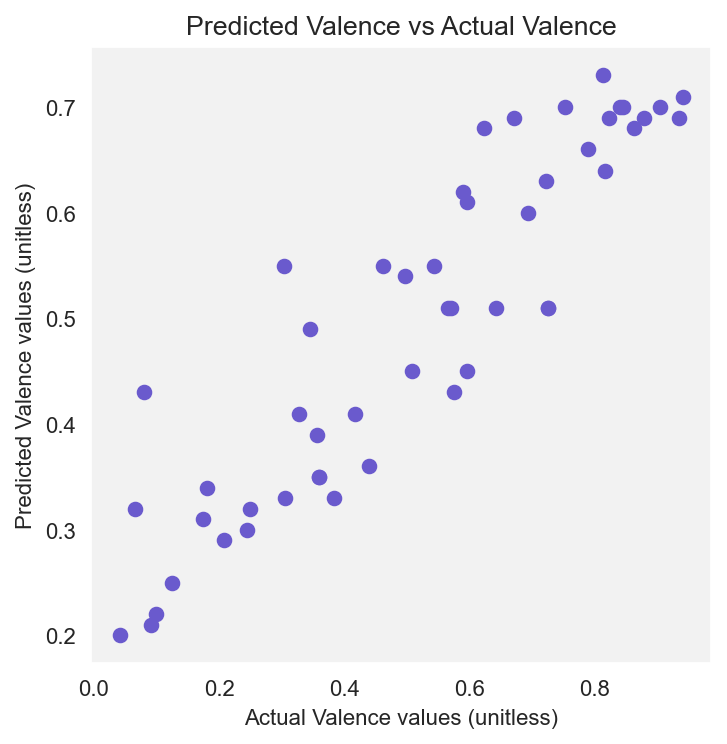

In [94]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(pred_table.valence, pred_table.valence_prediction, color='slateblue')
plt.xlabel('Actual Valence values (unitless)')
plt.ylabel('Predicted Valence values (unitless)')
plt.title('Predicted Valence vs Actual Valence')
plt.savefig('scatter.png', bbox_inches='tight')

#plt.plot()

In [45]:
import joblib 

# save the final model
joblib.dump(rf, "RandomForest_lyrics_data.pkl")

# upload and test that the model works
model = joblib.load("RandomForest_lyrics_data.pkl")

y_pred = model.predict(X_s)

r2 = r2_score(y_s, y_pred)
mae = mean_absolute_error(y_s, y_pred)

print("R^2: {:.4f}".format(r2))
print("MAE: {:.4f}".format(mae))


R^2: 0.6527
MAE: 0.1220


In [46]:
# Write a python script
def estimate_valence(file_path):

    features = get_features(file_path)
    model = joblib.load("RandomForest_lyrics_data.pkl")
    #CI = 2

    valence = model.predict(features)

    #lower = valence - CI
    #upper = valence + CI

    return valence, lower, upper
init_str = """
import joblib
import numpy as np
import librosa
"""

import inspect

with open("estimate_valence.py", "w") as f:

    f.write(init_str)
    f.write("\n\n")

    for fn_name in [get_stats, get_features, estimate_valence]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write("\n\n")

### Natural Langauge Processing (BERT) Model

In [47]:
# Create tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [48]:
# Create function to tokenize all rows
def tokenize_with_bert(texts):
    
    ids_list = []
    attention_mask_list = []

    for item in texts:
        token = tokenizer(text=item, add_special_tokens=True, padding= 'max_length', truncation=True, return_attention_mask=True, max_length=512)
        attention_mask = token['attention_mask']
        ids = token['input_ids']
        ids_list.append(ids)
        attention_mask_list.append(attention_mask)    
        
    return ids_list, attention_mask_list

In [49]:
# Tokenize all rows
ids_list, attention_mask_list= tokenize_with_bert(texts=df1['lyrics'])

In [50]:
# 
config = transformers.BertConfig.from_pretrained('bert-base-multilingual-cased')
model = transformers.BertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
# Generate embeddings
batch_size = 25    # typically the batch size is equal to 100 but we can set it to lower values to lower the memory requirements

embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {device} device.')
model.to(device)

for i in tqdm(range(len(ids_list) // batch_size)):
    
    ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        model.eval()
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

Using the cpu device.


100%|███████████████████████████████████████████| 14/14 [01:41<00:00,  7.22s/it]


In [64]:
# Create features and target
nlp_features = np.concatenate(embeddings) 
#bert_features = nlp_features
target = df1['valence']

In [65]:
# Visualize shape of parameters
print(nlp_features.shape)
print(target.shape)

(350, 768)
(350,)


In [54]:
# Split features and target into train and test datasets
features_train, features_test, target_train, target_test = train_test_split(nlp_features, target, test_size=0.2, random_state=12345)

In [55]:
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer


In [56]:
# Create scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [57]:
# Create and fit scaler
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [58]:
from sklearn.linear_model import LinearRegression


In [59]:
lr_model= LinearRegression()
lr_model.fit(features_train, target_train)

lr_pred = lr_model.predict(features_test)

print("MAE:", mean_absolute_error(target_test, lr_pred))

MAE: 0.32088025651795526


In [60]:
eval_model(LinearRegression(),features_train,target_train)

Fit time: 0.03832
Score time: 0.00134
R^2: -2.0221
MAE 0.3319


In [61]:
eval_model(RandomForestRegressor(),features_train,target_train)

Fit time: 3.82516
Score time: 0.00442
R^2: 0.0799
MAE 0.2059


# Conclusion
The aim of this task is to develop a Python-based module to predict the valence of newly released pop songs. The regression model using audio features only marginally performed better than the BERT model. Using a BERT model for text preprocessing and to generating embeddings proved to also be successful. This sample is very small and may not reflect the full dataset

- Audio features model yielded the best result; MAE: 0.1831
- BERT Lyrics Model MAE: 0.2059

## Insights



Future Steps:
- Further training the model based on such dataset and assess if val_MAE is improving.
- Using the valence predicted by the CNN  and the valence probability predicted for the songs’ lyrics by an NLP model as inputs to train a linear regression mixed model.
- Genre classification can also be completed using CNN
- Building a larger dataset by hiring a third-party provider (such as Appen) to rate Spotify songs preview’s valence.

